<a href="https://colab.research.google.com/github/ninja-marduk/ml_precipitation_prediction/blob/feature%2Fhybrid-models/models/base_models_Conv_STHyMOUNTAIN_V3_FNO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Version Control
## V3.0-FNO - 2025-12-23
- Based on V2 refactor; training loop, plots, metrics unchanged.
- Models restricted to lightweight FNO encoders + ConvLSTM decoder (`FNO_ConvLSTM_Hybrid`) and pseudo-FNO baseline (`FNO_Pure`).
- Horizon=12, window=60 by default; ready for BASIC/KCE/PAFC.
- Imports include StandardScaler and V2 helpers; MODELS override set to MODELS_V3_FNO.


<a href="https://colab.research.google.com/github/ninja-marduk/ml_precipitation_prediction/blob/feature%2Fhybrid-models/models/refactored_base_models_Conv_STHyMOUNTAIN_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spatio-Temporal Precipitation Prediction Models V3 (FNO)

## Overview

This V3 notebook reuses the V2 pipeline (data loading, preprocessing, training loop, plots, metrics) and swaps the model set to lightweight FNO variants:
- `FNO_ConvLSTM_Hybrid`: pseudo-FNO encoder (depthwise+pointwise with dilation) + ConvLSTM decoder.
- `FNO_Pure`: pseudo-FNO encoder-decoder without recurrent head.

Configuration stays identical to V2 (window=60, H=12, callbacks, logging). MODELS is overridden to `MODELS_V3_FNO` before the training loop. Use BASIC/KCE/PAFC feature sets; start with BASIC to check memory.


## Quick Info (V3_FNO)
- Horizon: 12 (CONFIG)
- Input window: 60
- Batch: configurable (default 1; adjust if memory allows)
- Models: FNO_ConvLSTM_Hybrid, FNO_Pure (MODELS_V3_FNO)
- Experiments: BASIC / KCE / PAFC (CONFIG['feature_sets'])
- Training loop, plotting, callbacks: unchanged from V2
- Outputs: under CONFIG['out_root'] (models/output/V3_FNO_Models)


In [1]:
# ==================================================
# ENVIRONMENT SETUP AND IMPORTS
# ==================================================

import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # Disable oneDNN before importing TensorFlow
import tensorflow as tf
tf.random.set_seed(42)  # Ensure reproducibility
import numpy as np
np.random.seed(42)
import pandas as pd
import xarray as xr
from pathlib import Path
import sys, os, gc, warnings
import json
import time
from datetime import datetime
from typing import Dict, List, Tuple, Optional
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, display, Image
import imageio.v2 as imageio

# TensorFlow/Keras imports
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, ConvLSTM2D, SimpleRNN, Flatten, Dense, Reshape,
    Lambda, Permute, Layer, TimeDistributed, Multiply, GlobalAveragePooling1D,
    Dropout, BatchNormalization, Add, Concatenate, Average,
    GlobalAveragePooling2D, MultiHeadAttention, LayerNormalization
)
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau, CSVLogger, EarlyStopping, ModelCheckpoint, TensorBoard, Callback
)
from tensorflow.keras.optimizers import Adam

# Visualization imports
CARTOPY_AVAILABLE = False
ccrs = None
gpd = None
fiona = None
imageio = None

try:
    import cartopy.crs as ccrs
    import geopandas as gpd
    import fiona
    import imageio.v2 as imageio
    CARTOPY_AVAILABLE = True
except ImportError:
    print("Cartopy or GeoPandas not available. Maps will use basic plotting.")
    CARTOPY_AVAILABLE = False
    ccrs = None
    gpd = None
    fiona = None
    imageio = None

# Configure GPU memory growth
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU memory growth configured for {len(gpus)} GPU(s)")
    else:
        print("No GPU detected - running on CPU")
except RuntimeError as e:
    print(f"GPU configuration warning: {e}")

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('notebook')
warnings.filterwarnings('ignore')
import logging
tf.get_logger().setLevel('ERROR')
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Detect environment
INSTALL_CARTOPY = False

# Detect environment
IN_COLAB = 'google.colab' in sys.modules

# Install dependencies in Colab with pinned versions
if IN_COLAB and INSTALL_CARTOPY:
    print("Installing dependencies in Colab...")
    try:
        # Install necessary dependencies
        !pip install -r requirements.txt
        !apt-get -qq update
        !apt-get -qq install libproj-dev proj-data proj-bin libgeos-dev
        !pip install -q --upgrade pip==24.0
        !pip install -q numpy==1.24.3 pandas==2.0.3 xarray==2023.6.0 netCDF4==1.6.5
        !pip install -q matplotlib==3.7.2 seaborn==0.12.2
        !pip install -q scikit-learn==1.3.0
        !pip install -q geopandas==0.13.2
        !pip install -q fiona==1.8.22 # Pin Fiona to a version compatible with geopandas 0.13.2
        !pip install -q --no-binary cartopy cartopy==0.22.0
        !pip install -q imageio==2.31.1
        !pip install optuna lightgbm ace_tools_open
        print("Dependencies installed successfully")
    except Exception as e:
        print(f"Error installing dependencies: {e}")

!pip install cartopy
import cartopy

print("Environment setup complete")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

No GPU detected - running on CPU
Environment setup complete
TensorFlow version: 2.20.0
NumPy version: 2.2.6
Pandas version: 2.3.3


In [2]:
# ==================================================
# CONFIGURATION AND CONSTANTS
# ==================================================

# Single-source configuration (JSON-friendly)
CONFIG_JSON = {
    'input_window': 60,
    'horizon': 12,
    'epochs': 80,
    'batch_size': 1,
    'learning_rate': 1e-3,
    'patience': 30,
    'light_mode': True,
    'light_grid_size': 5,
    'base_path': None,
    'data_file': None,
    'out_root': None,
    'enabled_horizons': [12],
    'loss_weighting': 'uniform',
    'save_window_metrics': False,
    'train_val_split': 0.8,
    'effective_batch_size': None,
    'prediction_batch_size': 1,
    'gradient_accumulation_steps': 1,
    'feature_sets': {
        'BASIC': ['year', 'month', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos',
                  'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std',
                  'elevation', 'slope', 'aspect'],
        'KCE': ['year', 'month', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos',
                  'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std',
                  'elevation', 'slope', 'aspect', 'elev_high','elev_med','elev_low'],
        'PAFC': ['year', 'month', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos',
                  'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std',
                  'elevation', 'slope', 'aspect', 'elev_high','elev_med','elev_low',
                  'total_precipitation_lag1','total_precipitation_lag2','total_precipitation_lag12']
    }
}

# Deep copy to runtime CONFIG
CONFIG = json.loads(json.dumps(CONFIG_JSON))

# Set paths
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    CONFIG['base_path'] = Path('/content/drive/MyDrive/ml_precipitation_prediction')
else:
    CONFIG['base_path'] = Path.cwd()
    for p in [CONFIG['base_path'], *CONFIG['base_path'].parents]:
        if (p / '.git').exists():
            CONFIG['base_path'] = p
            break

CONFIG['data_file'] = CONFIG['base_path'] / 'data' / 'output' / (
    'complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc'
)
CONFIG['out_root'] = CONFIG['base_path'] / 'models' / 'output' / 'V3_FNO_Models'
CONFIG['out_root'].mkdir(parents=True, exist_ok=True)

BASE_CONTINUOUS_FEATURES = ['year', 'month', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos',
    'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std',
    'elevation', 'slope', 'aspect']
ELEVATION_ONEHOT_FEATURES = ['elev_high', 'elev_med', 'elev_low']
PRECIP_LAG_FEATURES = ['total_precipitation_lag1', 'total_precipitation_lag2', 'total_precipitation_lag12']

print("Configuration complete")
print(f"Base path: {CONFIG['base_path']}")
print(f"Input window: {CONFIG['input_window']} months")
print(f"Prediction horizon: {CONFIG['horizon']} months")
print(f"Experiments: {list(CONFIG['feature_sets'].keys())}")
print(f"Output directory: {CONFIG['out_root']}")


Configuration complete
Base path: d:\github.com\ninja-marduk\ml_precipitation_prediction
Input window: 60 months
Prediction horizon: 12 months
Experiments: ['BASIC', 'KCE', 'PAFC']
Output directory: d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V3_FNO_Models


In [3]:
# ==================================================
# DATA LOADING AND VALIDATION
# ==================================================

def load_and_validate_data(config: Dict) -> Tuple[xr.Dataset, int, int]:
    """Load dataset and validate features, applying light mode if enabled."""
    data_file = config['data_file']
    light_mode = config['light_mode']
    light_grid_size = config['light_grid_size']

    print("Loading dataset...")
    if not data_file.exists():
        raise FileNotFoundError(f"Dataset not found: {data_file}")

    try:
        ds = xr.open_dataset(data_file)

        if light_mode:
            print(f"\n*** LIGHT MODE ENABLED: Using {light_grid_size}x{light_grid_size} pixel subset ***")
            lat_center = len(ds.latitude) // 2
            lon_center = len(ds.longitude) // 2
            lat_start = lat_center - light_grid_size // 2
            lat_end = lat_start + light_grid_size
            lon_start = lon_center - light_grid_size // 2
            lon_end = lon_start + light_grid_size
            ds = ds.isel(latitude=slice(lat_start, lat_end), longitude=slice(lon_start, lon_end))
            print(f"Subset extracted: lat[{lat_start}:{lat_end}], lon[{lon_start}:{lon_end}]")

        lat, lon = len(ds.latitude), len(ds.longitude)
        print(f"Dataset loaded successfully")
        print(f"Time steps: {len(ds.time)}")
        print(f"Spatial dimensions: {lat} x {lon}")
        print(f"Variables: {list(ds.data_vars)[:5]}...")

        # Validate features
        missing_feats = []
        for exp_name, feats in config['feature_sets'].items():
            for feat in feats:
                if feat not in ds.data_vars and feat not in ds.coords:
                    missing_feats.append(feat)
        if missing_feats:
            raise ValueError(f"Missing features in dataset: {set(missing_feats)}")
        print("All required features present in dataset")

        return ds, lat, lon

    except Exception as e:
        print(f"ERROR: Failed to load dataset: {e}")
        raise

# Load dataset
ds, lat, lon = load_and_validate_data(CONFIG)
print("Dataset ready for training")


Loading dataset...

*** LIGHT MODE ENABLED: Using 5x5 pixel subset ***
Subset extracted: lat[28:33], lon[30:35]
Dataset loaded successfully
Time steps: 518
Spatial dimensions: 5 x 5
Variables: ['total_precipitation', 'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std', 'month_sin']...
All required features present in dataset
Dataset ready for training


In [4]:
# ==================================================
# CUSTOM LAYERS AND LOSSES
# ==================================================

class ConvGRU2DCell(Layer):
    """Robust ConvGRU2D cell implementation."""
    def __init__(self, filters, kernel_size, padding='same', activation='tanh',
                 recurrent_activation='sigmoid', **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
                # Provide state_size/output_size upfront for RNN wrapper
        self.state_size = tf.TensorShape([None, None, self.filters])
        self.output_size = tf.TensorShape([None, None, self.filters])

    def build(self, input_shape):
        # Set state_size as a tuple for RNN compatibility
        height, width = input_shape[1], input_shape[2]
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(
            shape=(*self.kernel_size, input_dim, self.filters * 3),
            initializer='glorot_uniform', name='kernel')
        self.recurrent_kernel = self.add_weight(
            shape=(*self.kernel_size, self.filters, self.filters * 3),
            initializer='orthogonal', name='recurrent_kernel')
        self.bias = self.add_weight(
            shape=(self.filters * 3,), initializer='zeros', name='bias')
        super().build(input_shape)

    def call(self, inputs, states):
        h_tm1 = states[0]
        x_conv = K.conv2d(inputs, self.kernel, padding=self.padding)
        x_z, x_r, x_h = tf.split(x_conv, 3, axis=-1)
        h_conv = K.conv2d(h_tm1, self.recurrent_kernel, padding=self.padding)
        h_z, h_r, h_h = tf.split(h_conv, 3, axis=-1)
        b_z, b_r, b_h = tf.split(self.bias, 3)
        z = self.recurrent_activation(x_z + h_z + b_z)
        r = self.recurrent_activation(x_r + h_r + b_r)
        h_candidate = self.activation(x_h + r * h_h + b_h)
        h = (1 - z) * h_tm1 + z * h_candidate
        return h, [h]


    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        # Provide zero initial state with dynamic spatial dims
        if inputs is not None:
            dtype = dtype or inputs.dtype
            shape = tf.shape(inputs)
            b = shape[0] if batch_size is None else batch_size
            h = shape[-3]
            w = shape[-2]
            init = tf.zeros((b, h, w, self.filters), dtype=dtype)
            return [init]
        # Fallback: minimal spatial dims if inputs not provided
        if batch_size is None:
            batch_size = 1
        init = tf.zeros((batch_size, 1, 1, self.filters), dtype=dtype or tf.keras.backend.floatx())
        return [init]
    def get_config(self):
        config = super().get_config()
        config.update({
            'filters': self.filters, 'kernel_size': self.kernel_size, 'padding': self.padding,
            'activation': tf.keras.activations.serialize(self.activation),
            'recurrent_activation': tf.keras.activations.serialize(self.recurrent_activation)
        })
        return config

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[2], self.filters)

class ConvGRU2D(Layer):
    """Full ConvGRU2D with vectorized RNN processing."""
    def __init__(self, filters, kernel_size, padding='same', activation='tanh',
                 recurrent_activation='sigmoid', return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.activation = activation
        self.recurrent_activation = recurrent_activation
        self.return_sequences = return_sequences
        self.cell = ConvGRU2DCell(filters, kernel_size, padding, activation, recurrent_activation)
        self.rnn = tf.keras.layers.RNN(self.cell, return_sequences=return_sequences)

    def call(self, inputs):
        return self.rnn(inputs)

    def get_config(self):
        config = super().get_config()
        config.update({
            'filters': self.filters, 'kernel_size': self.kernel_size, 'padding': self.padding,
            'activation': self.activation, 'recurrent_activation': self.recurrent_activation,
            'return_sequences': self.return_sequences
        })
        return config

class MultiHorizonLoss(tf.keras.losses.Loss):
    """Weighted loss for multi-horizon forecasting (vectorized)."""
    def __init__(self, horizon_weights=[0.4, 0.35, 0.25], name='multi_horizon_loss'):
        super().__init__(name=name)
        self.horizon_weights = tf.constant(horizon_weights, dtype=tf.float32)
    def call(self, y_true, y_pred):
        y_pred = tf.maximum(y_pred, 0.0)
        mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=[2, 3, 4])
        weights = tf.reshape(self.horizon_weights, [1, -1])
        return tf.reduce_mean(tf.reduce_sum(mse * weights, axis=1))
    def get_config(self):
        config = super().get_config()
        config.update({'horizon_weights': self.horizon_weights.numpy().tolist()})
        return config

class TemporalConsistencyLoss(tf.keras.losses.Loss):
    """Regularization to enforce temporal smoothness."""
    def __init__(self, mse_weight=1.0, consistency_weight=0.1, name='temporal_consistency_loss'):
        super().__init__(name=name)
        self.mse_weight = mse_weight
        self.consistency_weight = consistency_weight
    def call(self, y_true, y_pred):
        y_pred = tf.maximum(y_pred, 0.0)
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
        temporal_diffs = tf.abs(y_pred[:, 1:, :, :, :] - y_pred[:, :-1, :, :, :])
        consistency_loss = tf.reduce_mean(temporal_diffs)
        return self.mse_weight * mse_loss + self.consistency_weight * consistency_loss
    def get_config(self):
        config = super().get_config()
        config.update({'mse_weight': self.mse_weight, 'consistency_weight': self.consistency_weight})
        return config

class CombinedLoss(tf.keras.losses.Loss):
    """Combines multi-horizon MSE with temporal consistency (vectorized)."""
    def __init__(self, horizon_weights=[0.4, 0.35, 0.25], consistency_weight=0.1, name='combined_loss'):
        super().__init__(name=name)
        self.horizon_weights = tf.constant(horizon_weights, dtype=tf.float32)
        self.consistency_weight = consistency_weight
    def call(self, y_true, y_pred):
        y_pred = tf.maximum(y_pred, 0.0)
        mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=[2, 3, 4])
        weights = tf.reshape(self.horizon_weights, [1, -1])
        mh_loss = tf.reduce_mean(tf.reduce_sum(mse * weights, axis=1))
        temporal_diffs = tf.abs(y_pred[:, 1:, :, :, :] - y_pred[:, :-1, :, :, :])
        tc_loss = tf.reduce_mean(temporal_diffs)
        return mh_loss + self.consistency_weight * tc_loss
    def get_config(self):
        config = super().get_config()
        config.update({'horizon_weights': self.horizon_weights.numpy().tolist(), 'consistency_weight': self.consistency_weight})
        return config

class SimpleTemporalAttention(Layer):
    """Temporal attention for sequence processing."""
    def __init__(self, units=64, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.attention_dense = Dense(1, activation='tanh')
        self.softmax = tf.keras.layers.Softmax(axis=1)
        super().build(input_shape)

    def call(self, inputs):
        attention_scores = self.attention_dense(inputs)
        attention_weights = self.softmax(attention_scores)
        context = tf.reduce_sum(inputs * attention_weights, axis=1)
        return context, attention_weights

    def get_config(self):
        config = super().get_config()
        config.update({'units': self.units})
        return config

class SpatialReshapeLayer(Layer):
    """Reshape for attention: (batch, time, height, width, channels) -> (batch, time, height*width*channels)."""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[2] * input_shape[3] * input_shape[4])

    def call(self, inputs):
        batch_size, time_steps, height, width, channels = tf.unstack(tf.shape(inputs))
        return tf.reshape(inputs, [batch_size, time_steps, height * width * channels])

    def get_config(self):
        return super().get_config()

class SpatialRestoreLayer(Layer):
    """Restore spatial dimensions after attention."""
    def __init__(self, height, width, channels, **kwargs):
        super().__init__(**kwargs)
        self.height = height
        self.width = width
        self.channels = channels

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.height, self.width, self.channels)

    def call(self, inputs):
        batch_size, time_steps, _ = tf.unstack(tf.shape(inputs))
        return tf.reshape(inputs, [batch_size, time_steps, self.height, self.width, self.channels])

    def get_config(self):
        config = super().get_config()
        config.update({'height': self.height, 'width': self.width, 'channels': self.channels})
        return config

print("Custom layers and losses defined")


Custom layers and losses defined


In [5]:
# ==================================================
# MODEL FACTORIES
# ==================================================
# ConvGRU2D helper embebido (sin import al modulo); intenta nativo, luego TFA y finalmente la implementacion custom
from typing import Tuple

try:
    from tensorflow.keras.layers import ConvGRU2D as _NativeConvGRU2D  # type: ignore
except Exception:
    _NativeConvGRU2D = None

def _get_from_tfa():
    try:
        import tensorflow_addons as tfa  # type: ignore
        return tfa.layers.ConvGRU2D
    except Exception:
        return None

def build_convgru2d_layer(
    filters: int,
    kernel_size: Tuple[int, int] = (3, 3),
    return_sequences: bool = True,
    padding: str = "same",
    name: str = "conv_gru2d",
    **kwargs,
):
    """
    Returns a ConvGRU2D layer if available.

    Tries native tf.keras first; if missing, tries tensorflow-addons.
    Falls back to the custom ConvGRU2D defined in the previous cell.
    Raises an ImportError with guidance when none are present.
    """
    layer_cls = _NativeConvGRU2D or _get_from_tfa()
    if layer_cls is not None:
        return layer_cls(
            filters=filters,
            kernel_size=kernel_size,
            return_sequences=return_sequences,
            padding=padding,
            name=name,
            **kwargs,
        )
    try:
        return ConvGRU2D(
            filters=filters,
            kernel_size=kernel_size,
            padding=padding,
            return_sequences=return_sequences,
            name=name,
            **kwargs,
        )
    except Exception as e:
        raise ImportError(
            "ConvGRU2D is not available in this TensorFlow/Keras build. "
            "Install TF >=2.12 or add tensorflow-addons."
        ) from e

try:
    _probe = build_convgru2d_layer(filters=4, kernel_size=(1, 1), return_sequences=True, name="conv_gru2d_probe")
    HAS_CONVGRU2D = _probe is not None
except Exception:
    HAS_CONVGRU2D = False

def _spatial_head(x, horizon: int, lat: int, lon: int) -> tf.Tensor:
    if len(x.shape) == 5:
        x = Lambda(lambda t: tf.squeeze(t, axis=1) if tf.shape(t)[1] == 1 else t[:, -1, :, :, :],
                   name="take_last_step")(x)
    x = Conv2D(horizon, (1, 1), padding="same", activation="linear", name="head_conv1x1")(x)
    x = Lambda(lambda t: tf.transpose(t, [0, 3, 1, 2]), name="head_transpose")(x)
    x = Lambda(lambda t: tf.expand_dims(t, -1), name="head_expand_dim")(x)
    return x


def _assert_model_output(model: Model, horizon: int, lat: int, lon: int):
    expected = (None, horizon, lat, lon, 1)
    actual = model.output_shape
    if actual != expected:
        raise ValueError(f'{model.name} output_shape {actual} != expected {expected}')


def build_conv_lstm(n_feats: int, lat: int, lon: int, horizon: int) -> Model:
    """Build ConvLSTM-based model."""
    inp = Input(shape=(None, lat, lon, n_feats))
    x = ConvLSTM2D(32, (3, 3), padding='same', return_sequences=True)(inp)
    x = ConvLSTM2D(16, (3, 3), padding='same', return_sequences=False)(x)
    out = _spatial_head(x, horizon, lat, lon)
    model = Model(inp, out, name='ConvLSTM')
    _assert_model_output(model, horizon, lat, lon)
    return model

def build_conv_gru(n_feats: int, lat: int, lon: int, horizon: int) -> Model:
    """Build ConvGRU-based model."""
    inp = Input(shape=(None, lat, lon, n_feats))
    x = build_convgru2d_layer(filters=32, kernel_size=(3, 3), padding="same", return_sequences=True, name="conv_gru2d_1")(inp)
    x = build_convgru2d_layer(filters=16, kernel_size=(3, 3), padding="same", return_sequences=False, name="conv_gru2d_2")(x)
    out = _spatial_head(x, horizon, lat, lon)
    model = Model(inp, out, name="ConvGRU")
    _assert_model_output(model, horizon, lat, lon)
    return model

def build_conv_rnn(n_feats: int, lat: int, lon: int, horizon: int) -> Model:
    """Build ConvRNN-based model."""
    inp = Input(shape=(None, lat, lon, n_feats))
    x = TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'))(inp)
    x = TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'))(x)
    x = TimeDistributed(Flatten())(x)
    x = SimpleRNN(128, activation='tanh', return_sequences=False)(x)
    x = Dense(horizon * lat * lon)(x)
    out = Reshape((horizon, lat, lon, 1))(x)
    model = Model(inp, out, name='ConvRNN')
    _assert_model_output(model, horizon, lat, lon)
    return model

def build_conv_lstm_enhanced(n_feats: int, lat: int, lon: int, horizon: int) -> Model:
    """Enhanced ConvLSTM with dropout and batch norm."""
    inp = Input(shape=(None, lat, lon, n_feats))
    x = ConvLSTM2D(32, (3, 3), padding='same', return_sequences=True)(inp)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = ConvLSTM2D(16, (3, 3), padding='same', return_sequences=False)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    out = _spatial_head(x, horizon, lat, lon)
    model = Model(inp, out, name='ConvLSTM_Enhanced')
    _assert_model_output(model, horizon, lat, lon)
    return model

def build_conv_gru_enhanced(n_feats: int, lat: int, lon: int, horizon: int) -> Model:
    """Enhanced ConvGRU with dropout and batch norm."""
    inp = Input(shape=(None, lat, lon, n_feats))
    x = build_convgru2d_layer(filters=32, kernel_size=(3, 3), padding="same", return_sequences=True, name="conv_gru2d_enh_1")(inp)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = build_convgru2d_layer(filters=16, kernel_size=(3, 3), padding="same", return_sequences=False, name="conv_gru2d_enh_2")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    out = _spatial_head(x, horizon, lat, lon)
    model = Model(inp, out, name="ConvGRU_Enhanced")
    _assert_model_output(model, horizon, lat, lon)
    return model

def build_conv_rnn_enhanced(n_feats: int, lat: int, lon: int, horizon: int) -> Model:
    """Enhanced ConvRNN with dropout."""
    inp = Input(shape=(None, lat, lon, n_feats))
    x = TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'))(inp)
    x = Dropout(0.2)(x)
    x = TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'))(x)
    x = Dropout(0.2)(x)
    x = TimeDistributed(Flatten())(x)
    x = SimpleRNN(128, activation='tanh', return_sequences=False)(x)
    x = Dense(horizon * lat * lon)(x)
    out = Reshape((horizon, lat, lon, 1))(x)
    model = Model(inp, out, name='ConvRNN_Enhanced')
    _assert_model_output(model, horizon, lat, lon)
    return model

def build_conv_lstm_bidirectional(n_feats: int, lat: int, lon: int, horizon: int) -> Model:
    """Bidirectional ConvLSTM."""
    inp = Input(shape=(None, lat, lon, n_feats))
    forward = ConvLSTM2D(32, (3, 3), padding='same', return_sequences=True)(inp)
    backward = ConvLSTM2D(32, (3, 3), padding='same', return_sequences=True, go_backwards=True)(inp)
    x = Concatenate()([forward, backward])
    x = ConvLSTM2D(16, (3, 3), padding='same', return_sequences=False)(x)
    out = _spatial_head(x, horizon, lat, lon)
    model = Model(inp, out, name='ConvLSTM_Bidirectional')
    _assert_model_output(model, horizon, lat, lon)
    return model

def build_conv_gru_residual(n_feats: int, lat: int, lon: int, horizon: int) -> Model:
    """ConvGRU with residual connections."""
    inp = Input(shape=(None, lat, lon, n_feats))
    x = build_convgru2d_layer(filters=32, kernel_size=(3, 3), padding="same", return_sequences=True, name="conv_gru2d_res_1")(inp)
    residual = x
    x = build_convgru2d_layer(filters=32, kernel_size=(3, 3), padding="same", return_sequences=True, name="conv_gru2d_res_2")(x)
    x = Add()([x, residual])
    x = build_convgru2d_layer(filters=16, kernel_size=(3, 3), padding="same", return_sequences=False, name="conv_gru2d_res_3")(x)
    out = _spatial_head(x, horizon, lat, lon)
    model = Model(inp, out, name="ConvGRU_Residual")
    _assert_model_output(model, horizon, lat, lon)
    return model

def build_conv_lstm_residual(n_feats: int, lat: int, lon: int, horizon: int) -> Model:
    """ConvLSTM with residual connections."""
    inp = Input(shape=(None, lat, lon, n_feats))
    x = ConvLSTM2D(32, (3, 3), padding='same', return_sequences=True)(inp)
    residual = x
    x = ConvLSTM2D(32, (3, 3), padding='same', return_sequences=True)(x)
    x = Add()([x, residual])
    x = ConvLSTM2D(16, (3, 3), padding='same', return_sequences=False)(x)
    out = _spatial_head(x, horizon, lat, lon)
    model = Model(inp, out, name='ConvLSTM_Residual')
    _assert_model_output(model, horizon, lat, lon)
    return model

def build_conv_lstm_attention_simple(n_feats: int, lat: int, lon: int, horizon: int) -> Model:
    """ConvLSTM with temporal attention."""
    inp = Input(shape=(None, lat, lon, n_feats))
    x = ConvLSTM2D(32, (3, 3), padding='same', return_sequences=True)(inp)
    reshape = SpatialReshapeLayer()(x)
    attention = SimpleTemporalAttention()(reshape)
    x = SpatialRestoreLayer(lat, lon, 32)(attention[0][:, tf.newaxis, :])
    x = ConvLSTM2D(16, (3, 3), padding='same', return_sequences=False)(x)
    out = _spatial_head(x, horizon, lat, lon)
    model = Model(inp, out, name='ConvLSTM_Attention')
    _assert_model_output(model, horizon, lat, lon)
    return model

def build_conv_gru_attention_simple(n_feats: int, lat: int, lon: int, horizon: int) -> Model:
    """ConvGRU with temporal attention."""
    inp = Input(shape=(None, lat, lon, n_feats))
    x = build_convgru2d_layer(filters=32, kernel_size=(3, 3), padding='same', return_sequences=True, name="conv_gru2d_attn_1")(inp)
    reshape = SpatialReshapeLayer()(x)
    attention = SimpleTemporalAttention()(reshape)
    x = SpatialRestoreLayer(lat, lon, 32)(attention[0][:, tf.newaxis, :])
    x = build_convgru2d_layer(filters=16, kernel_size=(3, 3), padding='same', return_sequences=False, name="conv_gru2d_attn_2")(x)
    out = _spatial_head(x, horizon, lat, lon)
    model = Model(inp, out, name='ConvGRU_Attention')
    _assert_model_output(model, horizon, lat, lon)
    return model

def build_conv_lstm_meteorological_attention_simple(n_feats: int, lat: int, lon: int, horizon: int) -> Model:
    """ConvLSTM with meteorological attention (temporal over flattened spatial features)."""
    inp = Input(shape=(None, lat, lon, n_feats))
    x = ConvLSTM2D(32, (3, 3), padding='same', return_sequences=True)(inp)
    x_flat = TimeDistributed(Flatten())(x)
    x_attn = MultiHeadAttention(num_heads=4, key_dim=64, output_shape=lat*lon*32)(x_flat, x_flat)
    x = Lambda(lambda t: tf.reshape(t, [tf.shape(t)[0], tf.shape(t)[1], lat, lon, 32]), name='mha_restore_spatial')(x_attn)
    x = ConvLSTM2D(16, (3, 3), padding='same', return_sequences=False)(x)
    out = _spatial_head(x, horizon, lat, lon)
    model = Model(inp, out, name='ConvLSTM_MeteoAttention')
    _assert_model_output(model, horizon, lat, lon)
    return model

def build_efficient_bidirectional_convlstm_simple(n_feats: int, lat: int, lon: int, horizon: int) -> Model:
    """Efficient bidirectional ConvLSTM."""
    inp = Input(shape=(None, lat, lon, n_feats))
    forward = ConvLSTM2D(16, (3, 3), padding='same', return_sequences=True)(inp)
    backward = ConvLSTM2D(16, (3, 3), padding='same', return_sequences=True, go_backwards=True)(inp)
    x = Concatenate()([forward, backward])
    x = ConvLSTM2D(16, (3, 3), padding='same', return_sequences=False)(x)
    out = _spatial_head(x, horizon, lat, lon)
    model = Model(inp, out, name='ConvLSTM_EfficientBidir')
    _assert_model_output(model, horizon, lat, lon)
    return model

def build_transformer_baseline_simple(n_feats: int, lat: int, lon: int, horizon: int) -> Model:
    """Baseline Transformer model."""
    inp = Input(shape=(None, lat, lon, n_feats))
    x = TimeDistributed(Flatten())(inp)  # Shape: (batch, time, lat*lon*features)
    x = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)  # Shape: (batch, time, lat*lon*features)
    x = LayerNormalization()(x)
    x = GlobalAveragePooling1D()(x)  # Shape: (batch, lat*lon*features)
    x = Dense(horizon * lat * lon)(x)
    out = Reshape((horizon, lat, lon, 1))(x)
    model = Model(inp, out, name='Transformer_Baseline')
    _assert_model_output(model, horizon, lat, lon)
    return model

# Model registry - all original models preserved
MODEL_REGISTRY = {
    'original': {
        'ConvLSTM': build_conv_lstm,
        'ConvGRU': build_conv_gru,
        'ConvRNN': build_conv_rnn
    },
    'enhanced': {
        'ConvLSTM_Enhanced': build_conv_lstm_enhanced,
        'ConvGRU_Enhanced': build_conv_gru_enhanced,
        'ConvRNN_Enhanced': build_conv_rnn_enhanced
    },
    'advanced': {
        'ConvLSTM_Bidirectional': build_conv_lstm_bidirectional,
        'ConvGRU_Residual': build_conv_gru_residual,
        'ConvLSTM_Residual': build_conv_lstm_residual
    },
    'attention': {
        'ConvLSTM_Attention': build_conv_lstm_attention_simple,
        'ConvGRU_Attention': build_conv_gru_attention_simple
    },
    'competitive': {
        'ConvLSTM_MeteoAttention': build_conv_lstm_meteorological_attention_simple,
        'ConvLSTM_EfficientBidir': build_efficient_bidirectional_convlstm_simple,
        'Transformer_Baseline': build_transformer_baseline_simple
    }
}

# Combine all models
MODELS = {}
for category in MODEL_REGISTRY.values():
    MODELS.update(category)

if not HAS_CONVGRU2D:
    for key in ["ConvGRU","ConvGRU_Enhanced","ConvGRU_Residual","ConvGRU_Attention"]:
        MODELS.pop(key, None)
    print("ConvGRU2D not available; ConvGRU models skipped")
print(f"Model registry initialized with {len(MODELS)} models across all categories")


ConvGRU2D not available; ConvGRU models skipped
Model registry initialized with 10 models across all categories


In [6]:

# ==================================================
# DATA PREPROCESSING
# ==================================================

def windowed_arrays(X: np.ndarray, y: np.ndarray, input_window: int, horizon: int, start_indices=None) -> Tuple[np.ndarray, np.ndarray]:
    """Create windowed arrays for sequence-to-sequence learning without leakage."""
    seq_X, seq_y = [], []
    T = len(X)
    if T < (input_window + horizon):
        raise ValueError(f"Not enough timesteps ({T}) to build windows for input_window={input_window}, horizon={horizon}")
    iterator = start_indices if start_indices is not None else range(T - input_window - horizon + 1)
    for start in iterator:
        if start < 0:
            continue
        end_w = start + input_window
        end_y = end_w + horizon
        if end_y > T:
            continue
        Xw = X[start:end_w]
        yw = y[end_w:end_y]
        if np.isnan(Xw).any() or np.isnan(yw).any():
            continue
        seq_X.append(Xw)
        seq_y.append(yw)
    if not seq_X:
        raise ValueError("No valid windows found after NaN filtering")
    return np.asarray(seq_X, dtype=np.float32), np.asarray(seq_y, dtype=np.float32)

def compute_split_indices(total_steps: int, input_window: int, horizon: int, split_ratio: float) -> Tuple[list, list]:
    """Return train/validation start indices ensuring no temporal leakage."""
    if total_steps < input_window + horizon:
        raise ValueError("Insufficient samples to compute split indices")
    cutoff = max(0, int(total_steps * split_ratio))
    max_start = total_steps - input_window - horizon + 1
    train_end = max(0, cutoff - input_window - horizon + 1)
    train_indices = list(range(0, train_end))
    val_start = min(max_start, max(cutoff, 0))
    val_indices = list(range(val_start, max_start))
    if not train_indices or not val_indices:
        raise ValueError("Split configuration produced empty train/validation windows")
    return train_indices, val_indices

def scale_feature_blocks(X_tr: np.ndarray, X_va: np.ndarray, features: list[str]) -> Tuple[np.ndarray, np.ndarray]:
    """Scale continuous/lag blocks independently and keep categorical blocks bounded."""
    X_tr_scaled = X_tr.copy()
    X_va_scaled = X_va.copy()
    def apply_scaler(idxs: list[int]):
        if not idxs:
            return None
        scaler = StandardScaler()
        tr_block = X_tr[..., idxs].reshape(-1, len(idxs))
        va_block = X_va[..., idxs].reshape(-1, len(idxs))
        scaler.fit(tr_block)
        X_tr_scaled[..., idxs] = scaler.transform(tr_block).reshape(X_tr[..., idxs].shape)
        X_va_scaled[..., idxs] = scaler.transform(va_block).reshape(X_va[..., idxs].shape)
        return scaler
    cont_indices = [i for i, feat in enumerate(features) if feat in BASE_CONTINUOUS_FEATURES]
    lag_indices = [i for i, feat in enumerate(features) if feat in PRECIP_LAG_FEATURES]
    apply_scaler(cont_indices)
    apply_scaler(lag_indices)
    cat_indices = [i for i, feat in enumerate(features) if feat in ELEVATION_ONEHOT_FEATURES]
    if cat_indices:
        X_tr_scaled[..., cat_indices] = np.clip(X_tr_scaled[..., cat_indices], 0.0, 1.0)
        X_va_scaled[..., cat_indices] = np.clip(X_va_scaled[..., cat_indices], 0.0, 1.0)
    return X_tr_scaled, X_va_scaled

def preprocess_data(ds: xr.Dataset, config: Dict, lat: int, lon: int, horizon: int) -> Dict[str, Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, StandardScaler]]:
    """Preprocess data per experiment with no leakage; return y_scaler."""
    data_splits = {}
    split_ratio = config.get('train_val_split', 0.8)
    for exp_name, features in config['feature_sets'].items():
        print(f"Preprocessing {exp_name}...")
        X = np.stack([ds[feat].values for feat in features], axis=-1)
        y = ds['total_precipitation'].values[..., np.newaxis]
        total_steps = X.shape[0]
        train_idx, val_idx = compute_split_indices(total_steps, config['input_window'], horizon, split_ratio)
        X_tr, y_tr = windowed_arrays(X, y, config['input_window'], horizon, train_idx)
        X_va, y_va = windowed_arrays(X, y, config['input_window'], horizon, val_idx)
        X_tr_s, X_va_s = scale_feature_blocks(X_tr, X_va, features)
        y_scaler = StandardScaler()
        y_tr_s = y_scaler.fit_transform(y_tr.reshape(-1, 1)).reshape(y_tr.shape)
        y_va_s = y_scaler.transform(y_va.reshape(-1, 1)).reshape(y_va.shape)
        data_splits[exp_name] = (X_tr_s.astype(np.float32), y_tr_s.astype(np.float32),
                                 X_va_s.astype(np.float32), y_va_s.astype(np.float32), y_scaler)
        print(f"{exp_name} processed: {X_tr.shape[0]} train windows, {X_va.shape[0]} validation windows")
    return data_splits


In [7]:
# ==================================================
# TRAINING HELPERS
# ==================================================

import json, time, logging
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback

if 'compute_horizon_weights' not in globals():
    def compute_horizon_weights(H:int, strategy:str='uniform'):
        import numpy as np
        if H <= 0:
            return []
        if strategy == 'uniform':
            w = np.ones(H, dtype=np.float32)
        elif strategy == 'linear_decay':
            w = np.linspace(1.0, 0.2, H, dtype=np.float32)
        elif strategy == 'front_heavy':
            w = np.array([1.5**(H-1-i) for i in range(H)], dtype=np.float32)
        else:
            w = np.ones(H, dtype=np.float32)
        s = float(w.sum()) if float(w.sum()) != 0 else 1.0
        return (w / s).tolist()

if 'validate_shapes' not in globals():
    def validate_shapes(X: np.ndarray, y: np.ndarray, model_name: str, expected_input_shape: tuple, expected_horizon: int):
        try:
            if X.shape[1:] != expected_input_shape:
                raise ValueError(f"Invalid input shape for {model_name}: expected {expected_input_shape}, got {X.shape[1:]}")
            if y.shape[1:] != (expected_horizon, lat, lon, 1):
                raise ValueError(f"Invalid output shape for {model_name}: expected {(expected_horizon, lat, lon, 1)}, got {y.shape[1:]}")
            print(f"Shapes validated for {model_name}: X={X.shape}, y={y.shape}")
        except Exception as e:
            print(f"Shape validation error for {model_name}: {e}")
            raise

if 'save_hyperparameters' not in globals():
    def save_hyperparameters(metrics_dir: Path, model_name: str, hyperparams: dict):
        metrics_dir.mkdir(parents=True, exist_ok=True)
        try:
            with open(metrics_dir / f"{model_name}_hyperparameters.json", 'w') as f:
                json.dump(hyperparams, f, indent=4)
        except Exception as e:
            print(f"Error saving hyperparameters for {model_name}: {e}")

if 'TrainingMonitor' not in globals():
    class TrainingMonitor(Callback):
        def __init__(self, model_name, exp_name):
            super().__init__()
            self.model_name = model_name
            self.exp_name = exp_name
            self.start_time = None
            self.lrs = []
        def on_train_begin(self, logs=None):
            self.start_time = time.time()
        def on_epoch_end(self, epoch, logs=None):
            elapsed = time.time() - self.start_time
            try:
                lr = float(self.model.optimizer.learning_rate)
            except Exception:
                try:
                    lr = float(self.model.optimizer.lr)
                except Exception:
                    lr = 0.0
            self.lrs.append(lr)
            loss = logs.get('loss', np.nan) if logs else np.nan
            vloss = logs.get('val_loss', np.nan) if logs else np.nan
            print(f"{self.exp_name} - {self.model_name} | Epoch {epoch+1} | Loss: {loss:.4f} | Val Loss: {vloss:.4f} | LR: {lr:.2e} | Elapsed: {elapsed:.0f}s")

if 'print_training_summary' not in globals():
    def print_training_summary(history: dict, model_name: str, exp_name: str):
        try:
            best_val = float(min(history['val_loss']))
            print(f"\nTraining Summary - {exp_name} - {model_name}:")
            print(f"Best validation loss: {best_val:.4f}")
            print(f"Trained epochs: {len(history['loss'])}")
        except Exception as e:
            print(f"Error in training summary for {model_name}: {e}")

if 'plot_learning_curves' not in globals():
    def plot_learning_curves(history: dict, metrics_dir: Path, model_name: str, show: bool = True):
        try:
            fig, ax = plt.subplots(figsize=(10, 6))
            epochs = range(1, len(history['loss']) + 1)
            ax.plot(epochs, history['loss'], 'b-', label='Train Loss')
            ax.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
            if len(history['val_loss']) > 0:
                import numpy as np
                best_ep = int(np.argmin(history['val_loss'])) + 1
                best_val = float(min(history['val_loss']))
                ax.plot(best_ep, best_val, 'r*', markersize=12, label=f'Best: {best_val:.4f}')
            ax.set_title(f'Learning Curve - {model_name}')
            ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
            ax.grid(alpha=0.3, linestyle='--'); ax.legend(loc='upper right')
            metrics_dir.mkdir(parents=True, exist_ok=True)
            plt.savefig(metrics_dir / f"{model_name}_learning_curve.png", dpi=300, bbox_inches='tight')
            if show: plt.show()
            plt.close(fig)
        except Exception as e:
            print(f"Error plotting learning curves for {model_name}: {e}")

def batch_predict(model: tf.keras.models.Model, X: np.ndarray, batch_size: int = 1, squeeze: bool = False) -> np.ndarray:
    """Predict in mini-batches robustly and return concatenated array.
    - Validates consistent output shape across batches
    - Handles last partial batch
    - Accepts numpy arrays or array-like
    """
    import numpy as np, math
    try:
        X = np.asarray(X)
        n_samples = int(X.shape[0])
        if n_samples == 0:
            return np.empty((0,), dtype=X.dtype)
        if batch_size is None or batch_size <= 0:
            batch_size = n_samples
        num_batches = int(math.ceil(n_samples / float(batch_size)))
        predictions = []
        out_shape = None
        for b in range(num_batches):
            start = b * batch_size
            end = min(n_samples, start + batch_size)
            batch_X = X[start:end]
            print(f"Predicting batch {b+1}/{num_batches}, shape: {batch_X.shape}")
            batch_pred = model.predict(batch_X, verbose=0, batch_size=batch_size)
            bp = np.asarray(batch_pred)
            if out_shape is None:
                out_shape = bp.shape[1:]
            elif bp.shape[1:] != out_shape:
                raise ValueError(f"Inconsistent prediction shapes across batches: {bp.shape} vs (None,{out_shape})")
            predictions.append(bp)
        Y = np.concatenate(predictions, axis=0)
        return np.squeeze(Y) if squeeze else Y
    except Exception as e:
        print(f"Error in batch_predict: {e}")
        raise



In [8]:
# ==================================================
# UNIT TESTS (Enhanced)
# ==================================================

def run_unit_tests(config: Dict, lat: int, lon: int) -> Dict[str, str]:
    """Robust unit tests to catch shape and API regressions early."""
    import numpy as np
    results: Dict[str, str] = {}
    B = 2
    T = config['input_window']
    test_n_feats = 15
    try:
        _convgru_layer = build_convgru2d_layer(filters=16, kernel_size=(3, 3), padding='same', return_sequences=False, name="conv_gru2d_test")
        HAS_CONVGRU2D = True
    except Exception:
        HAS_CONVGRU2D = False


    # 1) Keras ConvGRU sanity
    try:
        if HAS_CONVGRU2D:
            layer = _convgru_layer
            x = tf.random.normal((B, T, lat, lon, test_n_feats))
            y = layer(x)
            exp = (B, lat, lon, 16)
            results['ConvGRU2D_layer'] = 'SUCCESS' if tuple(y.shape) == exp else f'SHAPE_MISMATCH: {y.shape}'
            tf.keras.backend.clear_session()
        else:
            results['ConvGRU2D_layer'] = 'SKIPPED: ConvGRU2D not available in this TF/Keras'
    except Exception as e:
        results['ConvGRU2D_layer'] = f'FAILED: {str(e)[:120]}'

    # 2) Losses finite + monotonicity
    try:
        for H in config['enabled_horizons']:
            y_true = tf.zeros((B, H, lat, lon, 1))
            y_pred_good = tf.zeros_like(y_true)
            y_pred_bad = tf.ones_like(y_true)
            mh = MultiHorizonLoss(horizon_weights=[1.0/H]*H)
            cbl = CombinedLoss(horizon_weights=[1.0/H]*H)
            v_good = float(tf.reduce_mean(mh(y_true, y_pred_good)).numpy())
            v_bad = float(tf.reduce_mean(mh(y_true, y_pred_bad)).numpy())
            assert np.isfinite(v_good) and np.isfinite(v_bad)
            assert v_good <= v_bad + 1e-6
            v2_good = float(tf.reduce_mean(cbl(y_true, y_pred_good)).numpy())
            v2_bad = float(tf.reduce_mean(cbl(y_true, y_pred_bad)).numpy())
            assert np.isfinite(v2_good) and np.isfinite(v2_bad)
            assert v2_good <= v2_bad + 1e-6
        results['Losses'] = 'SUCCESS'
    except Exception as e:
        results['Losses'] = f'FAILED: {str(e)[:120]}'

    # 3) compute_horizon_weights integrity
    try:
        for H in config['enabled_horizons']:
            for strat in ['uniform','linear_decay','front_heavy']:
                w = compute_horizon_weights(H, strat)
                assert len(w) == H
                s = float(np.sum(w))
                assert abs(s - 1.0) < 1e-5
        results['HorizonWeights'] = 'SUCCESS'
    except Exception as e:
        results['HorizonWeights'] = f'FAILED: {str(e)[:120]}'

    # 4) Model output shapes across horizons
    for H in config['enabled_horizons']:
        for name, builder in MODELS.items():
            try:
                if (not HAS_CONVGRU2D) and name.startswith('ConvGRU'):
                    results[f'{name}_H{H}'] = 'SKIPPED: ConvGRU2D not available'; continue
                tf.keras.backend.clear_session()
                model = builder(test_n_feats, lat, lon, H)
                x = tf.random.normal((B, T, lat, lon, test_n_feats))
                y = model(x, training=False)
                exp = (B, H, lat, lon, 1)
                ok = tuple(y.shape) == exp
                results[f'{name}_H{H}'] = 'SUCCESS' if ok else f'SHAPE_MISMATCH: {y.shape} != {exp}'
            except Exception as e:
                results[f'{name}_H{H}'] = f'FAILED: {str(e)[:120]}'

    # 5) batch_predict sanity
    try:
        for H in config['enabled_horizons']:
            inp = tf.keras.Input(shape=(T, lat, lon, test_n_feats))
            out = tf.keras.layers.Lambda(lambda t: tf.zeros((tf.shape(t)[0], H, lat, lon, 1), dtype=t.dtype))(inp)
            dummy_model = tf.keras.Model(inp, out)
            X = tf.random.normal((3, T, lat, lon, test_n_feats)).numpy()
            Y = batch_predict(dummy_model, X, batch_size=1)
            assert Y.shape == (3, H, lat, lon, 1)
        results['BatchPredict'] = 'SUCCESS'
    except Exception as e:
        results['BatchPredict'] = f'FAILED: {str(e)[:120]}'

    print('Unit Test Results:')
    for k,v in results.items():
        print(f'{k}: {v}')
    return results

# Run tests
test_results = run_unit_tests(CONFIG, lat, lon)


Predicting batch 1/3, shape: (1, 60, 5, 5, 15)
Predicting batch 2/3, shape: (1, 60, 5, 5, 15)
Predicting batch 3/3, shape: (1, 60, 5, 5, 15)
Unit Test Results:
ConvGRU2D_layer: SKIPPED: ConvGRU2D not available in this TF/Keras
Losses: SUCCESS
HorizonWeights: SUCCESS
ConvLSTM_H12: SUCCESS
ConvRNN_H12: SUCCESS
ConvLSTM_Enhanced_H12: SUCCESS
ConvRNN_Enhanced_H12: SUCCESS
ConvLSTM_Bidirectional_H12: SUCCESS
ConvLSTM_Residual_H12: SUCCESS
ConvLSTM_Attention_H12: SUCCESS
ConvLSTM_MeteoAttention_H12: SUCCESS
ConvLSTM_EfficientBidir_H12: SUCCESS
Transformer_Baseline_H12: SUCCESS
BatchPredict: SUCCESS


In [9]:

# ==================================================
# MODEL TRAINING
# ==================================================

def train_model(model: tf.keras.models.Model, X_tr: np.ndarray, y_tr: np.ndarray, X_va: np.ndarray, y_va: np.ndarray,
                config: dict, model_name: str, exp_name: str, out_dir: Path, horizon: int) -> tuple[tf.keras.models.Model, dict]:
    """Train a single model with callbacks and save results."""
    metrics_dir = out_dir / f'h{horizon}' / exp_name / 'training_metrics'
    metrics_dir.mkdir(parents=True, exist_ok=True)
    model_path = metrics_dir / f"{model_name}_best_h{horizon}.weights.h5"

    num_features = len(config['feature_sets'][exp_name])
    expected_input_shape = (config['input_window'], lat, lon, num_features)
    try:
        validate_shapes(X_tr, y_tr, model_name, expected_input_shape, expected_horizon=horizon)
        validate_shapes(X_va, y_va, model_name, expected_input_shape, expected_horizon=horizon)
        print(f"Training {model_name} in {exp_name} - X_tr shape: {X_tr.shape}, y_tr shape: {y_tr.shape}, "
              f"X_va shape: {X_va.shape}, y_va shape: {y_va.shape}")
    except ValueError as e:
        print(f"Shape validation error for {model_name}: {e}")
        return model, {}

    try:
        hyperparams = {
            'input_shape': expected_input_shape,
            'learning_rate': config['learning_rate'],
            'batch_size': config['batch_size'],
            'train_batch_size': int(max(1, config.get('effective_batch_size') or max(1, config['batch_size']//2))),
            'epochs': config['epochs'],
            'patience': config['patience'],
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'model_params': model.count_params(),
            'version': 'V2_Enhanced'
        }
        save_hyperparameters(metrics_dir, model_name, hyperparams)
    except (KeyError, NameError) as e:
        print(f"Error setting hyperparameters for {model_name}: {e}")
        return model, {}

    try:
        if exp_name == 'BASIC':
            loss = 'mse'
        else:
            horizon_weights = compute_horizon_weights(horizon, config.get('loss_weighting', 'uniform'))
            consistency_weight = 0.1 if exp_name == 'KCE' else 0.15
            loss = CombinedLoss(horizon_weights=horizon_weights, consistency_weight=consistency_weight)
    except NameError as e:
        print(f"Error selecting loss for {model_name}: {e}")
        return model, {}

    try:
        model.compile(optimizer=Adam(config['learning_rate']), loss=loss, metrics=['mae'])
        print(f"Model {model_name} compiled successfully")
        model.summary()
    except Exception as e:
        print(f"Error compiling model {model_name}: {e}")
        return model, {}

    try:
        csv_logger = CSVLogger(str(metrics_dir / f"{model_name}_training_log_h{horizon}.csv"), separator=',', append=False)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=max(1, config['patience']//2), min_lr=1e-6, verbose=1)
        early_stop = EarlyStopping(monitor='val_loss', patience=config['patience'], restore_best_weights=True, verbose=1)
        checkpoint = ModelCheckpoint(str(model_path), save_best_only=True, monitor='val_loss', verbose=1, save_weights_only=True)
        training_monitor = TrainingMonitor(model_name, exp_name)
        tensorboard = TensorBoard(log_dir=str(metrics_dir / f"{model_name}_logs"))
        callbacks = [early_stop, checkpoint, reduce_lr, csv_logger, training_monitor, tensorboard]
    except Exception as e:
        print(f"Error setting callbacks for {model_name}: {e}")
        return model, {}

    adaptive_batch = config.get('effective_batch_size')
    if adaptive_batch is None:
        fallback = max(1, config['batch_size']//2)
        adaptive_batch = fallback if fallback > 0 else config['batch_size']
    train_batch = max(1, adaptive_batch)
    print(f"Starting training for {model_name} in {exp_name} with batch_size={train_batch}...")
    try:
        history = model.fit(
            X_tr, y_tr,
            validation_data=(X_va, y_va),
            epochs=config['epochs'], batch_size=train_batch,
            callbacks=callbacks, verbose=0
        )
    except Exception as e:
        print(f"Error during training of {model_name}: {e}")
        return model, {}

    try:
        lr_values = history.history.get('lr', training_monitor.lrs)
        val_losses = history.history['val_loss']
        best_idx = int(np.argmin(val_losses))
        history_dict = {
            'loss': [float(x) for x in history.history['loss']],
            'val_loss': [float(x) for x in val_losses],
            'mae': [float(x) for x in history.history.get('mae', [])],
            'val_mae': [float(x) for x in history.history.get('val_mae', [])],
            'lr': [float(x) for x in lr_values],
            'best_epoch': best_idx,
            'best_val_loss': float(val_losses[best_idx]),
            'best_train_loss': float(history.history['loss'][best_idx]),
            'train_val_gap': float(history.history['loss'][best_idx] - val_losses[best_idx])
        }
        with open(metrics_dir / f"{model_name}_history.json", 'w') as f:
            json.dump(history_dict, f, indent=4)
    except Exception as e:
        print(f"Error saving history for {model_name}: {e}")
        history_dict = {}

    print_training_summary(history_dict, model_name, exp_name)
    plot_learning_curves(history_dict, metrics_dir, model_name, show=True)

    return model, history_dict


In [10]:

# ==================================================
# V3: FNO LIGHTWEIGHT BUILDERS (ENCODER) + CONVLSTM DECODER
# ==================================================
import tensorflow as tf
from tensorflow.keras import layers as L


def fno_block_light(x, width=32, activation='gelu', name_prefix='fno'):
    dw = L.DepthwiseConv2D(5, dilation_rate=2, padding='same', activation=None,
                           name=f'{name_prefix}_dw')(x)
    pw = L.Conv2D(width, 1, activation=activation, padding='same', name=f'{name_prefix}_pw')(dw)
    skip = L.Conv2D(width, 1, activation=activation, padding='same', name=f'{name_prefix}_skip')(x)
    out = L.Add(name=f'{name_prefix}_res')([pw, skip])
    out = L.LayerNormalization(name=f'{name_prefix}_ln')(out)
    return out


def build_fno_convlstm_hybrid(n_feats, width=32, horizon=None):
    """Encoder pseudo-FNO + ConvLSTM decoder (Keras-safe)."""
    if horizon is None:
        horizon = CONFIG['horizon']
    inp = L.Input(shape=(CONFIG['input_window'], lat, lon, n_feats), name='input_fno_lstm')
    merged = L.Lambda(lambda t: tf.reshape(t, (-1, lat, lon, tf.shape(t)[-1])), name='merge_bt')(inp)
    enc = fno_block_light(merged, width=width, activation='gelu', name_prefix='fno1')
    enc = fno_block_light(enc, width=width, activation='gelu', name_prefix='fno2')
    enc = L.Lambda(lambda t: tf.reshape(t, (-1, CONFIG['input_window'], lat, lon, width)), name='unmerge_bt')(enc)
    x = L.ConvLSTM2D(filters=width, kernel_size=3, padding='same', return_sequences=True, name='convlstm_dec1')(enc)
    x = L.ConvLSTM2D(filters=width//2, kernel_size=3, padding='same', return_sequences=False, name='convlstm_dec2')(x)
    x = L.Conv2D(width//2, 1, activation='gelu', padding='same')(x)
    x = L.LayerNormalization()(x)
    x = L.Conv2D(horizon, 1, activation='linear', padding='same', name='head_conv')(x)
    x = L.Permute((3,1,2))(x)
    out = L.Lambda(lambda z: tf.expand_dims(z, axis=-1))(x)
    return tf.keras.Model(inp, out, name='FNO_ConvLSTM_Hybrid')


def build_fno_pure(n_feats, width=32, horizon=None):
    """Pseudo-FNO encoder-decoder sin recurrente (Keras-safe)."""
    if horizon is None:
        horizon = CONFIG['horizon']
    inp = L.Input(shape=(CONFIG['input_window'], lat, lon, n_feats), name='input_fno_pure')
    merged = L.Lambda(lambda t: tf.reshape(t, (-1, lat, lon, tf.shape(t)[-1])), name='merge_bt_pure')(inp)
    x = fno_block_light(merged, width=width, activation='gelu', name_prefix='fno_p1')
    x = fno_block_light(x, width=width, activation='gelu', name_prefix='fno_p2')
    x = L.Conv2D(horizon, 1, activation='linear', padding='same')(x)
    x = L.Lambda(
        lambda t: tf.reshape(t, (-1, CONFIG['input_window'], lat, lon, horizon)),
        name='unmerge_bt_pure'
    )(x)
    x = L.Lambda(lambda t: tf.reduce_mean(t, axis=1), name='temporal_avg')(x)
    x = L.Permute((3,1,2))(x)
    out = L.Lambda(lambda z: tf.expand_dims(z, axis=-1), name='add_channel')(x)
    return tf.keras.Model(inp, out, name='FNO_Pure')

MODELS_V3_FNO = {
    'FNO_ConvLSTM_Hybrid': lambda n_feats, *args, **kwargs: build_fno_convlstm_hybrid(n_feats, width=32),
    'FNO_Pure': lambda n_feats, *args, **kwargs: build_fno_pure(n_feats, width=32),
}
MODELS = MODELS_V3_FNO
print(f"Using MODELS_V3_FNO for training: {list(MODELS.keys())}")


Using MODELS_V3_FNO for training: ['FNO_ConvLSTM_Hybrid', 'FNO_Pure']


=== Running experiments for horizon H=12 months ===
Preprocessing BASIC...
BASIC processed: 343 train windows, 33 validation windows
Preprocessing KCE...
KCE processed: 343 train windows, 33 validation windows
Preprocessing PAFC...
PAFC processed: 343 train windows, 33 validation windows
BASIC: X_tr=(343, 60, 5, 5, 12), y_tr=(343, 12, 5, 5, 1), X_va=(33, 60, 5, 5, 12), y_va=(33, 12, 5, 5, 1)
Building FNO_ConvLSTM_Hybrid with 12 features, lat=5, lon=5, horizon=12
Shapes validated for FNO_ConvLSTM_Hybrid: X=(343, 60, 5, 5, 12), y=(343, 12, 5, 5, 1)
Shapes validated for FNO_ConvLSTM_Hybrid: X=(33, 60, 5, 5, 12), y=(33, 12, 5, 5, 1)
Training FNO_ConvLSTM_Hybrid in BASIC - X_tr shape: (343, 60, 5, 5, 12), y_tr shape: (343, 12, 5, 5, 1), X_va shape: (33, 60, 5, 5, 12), y_va shape: (33, 12, 5, 5, 1)
Model FNO_ConvLSTM_Hybrid compiled successfully


Model: "FNO_ConvLSTM_Hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_fno_lstm      │ (None, 60, 5, 5,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merge_bt (Lambda)   │ (None, 5, 5, 12)  │          0 │ input_fno_lstm[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno1_dw             │ (None, 5, 5, 12)  │        312 │ merge_bt[0][0]    │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno1_pw (Conv2D)    │ (None, 5, 5, 32)  │        416 │ fno1_dw[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno1_skip (Conv2D)  │ (None, 5, 5, 32)  │        416 │ merge_bt[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno1_res (Add)      │ (None, 5, 5, 32)  │          0 │ fno1_pw[0][0],    │
│                     │                   │            │ fno1_skip[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno1_ln             │ (None, 5, 5, 32)  │         64 │ fno1_res[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno2_dw             │ (None, 5, 5, 32)  │        832 │ fno1_ln[0][0]     │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno2_pw (Conv2D)    │ (None, 5, 5, 32)  │      1,056 │ fno2_dw[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno2_skip (Conv2D)  │ (None, 5, 5, 32)  │      1,056 │ fno1_ln[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno2_res (Add)      │ (None, 5, 5, 32)  │          0 │ fno2_pw[0][0],    │
│                     │                   │            │ fno2_skip[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno2_ln             │ (None, 5, 5, 32)  │         64 │ fno2_res[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ unmerge_bt (Lambda) │ (None, 60, 5, 5,  │          0 │ fno2_ln[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convlstm_dec1       │ (None, 60, 5, 5,  │     73,856 │ unmerge_bt[0][0]  │
│ (ConvLSTM2D)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convlstm_dec2       │ (None, 5, 5, 16)  │     27,712 │ convlstm_dec1[0]… │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 5, 5, 16)  │        272 │ convlstm_dec2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 5, 5, 16)  │         32 │ conv2d[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_conv (Conv2D)  │ (None, 5, 5, 12)  │        204 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 12, 5, 5)  │          0 │ head_conv[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 106,292 (415.20 KB)

 Trainable params: 106,292 (415.20 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for FNO_ConvLSTM_Hybrid in BASIC with batch_size=1...

Epoch 1: val_loss improved from None to 0.80875, saving model to d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V3_FNO_Models\h12\BASIC\training_metrics\FNO_ConvLSTM_Hybrid_best_h12.weights.h5
BASIC - FNO_ConvLSTM_Hybrid | Epoch 1 | Loss: 0.7039 | Val Loss: 0.8088 | LR: 1.00e-03 | Elapsed: 41s

Epoch 2: val_loss improved from 0.80875 to 0.67698, saving model to d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V3_FNO_Models\h12\BASIC\training_metrics\FNO_ConvLSTM_Hybrid_best_h12.weights.h5
BASIC - FNO_ConvLSTM_Hybrid | Epoch 2 | Loss: 0.3899 | Val Loss: 0.6770 | LR: 1.00e-03 | Elapsed: 74s

Epoch 3: val_loss improved from 0.67698 to 0.64438, saving model to d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V3_FNO_Models\h12\BASIC\training_metrics\FNO_ConvLSTM_Hybrid_best_h12.weights.h5
BASIC - FNO_ConvLSTM_Hybrid | Epoch 3 | Loss: 0.3445 | Val Loss: 0.644

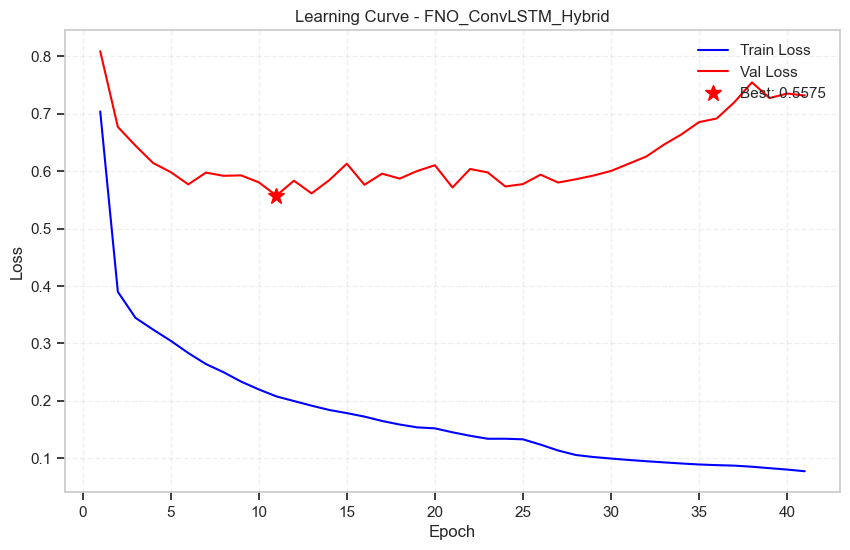

Generating predictions for FNO_ConvLSTM_Hybrid in BASIC...
Predicting batch 1/33, shape: (1, 60, 5, 5, 12)
Predicting batch 2/33, shape: (1, 60, 5, 5, 12)
Predicting batch 3/33, shape: (1, 60, 5, 5, 12)
Predicting batch 4/33, shape: (1, 60, 5, 5, 12)
Predicting batch 5/33, shape: (1, 60, 5, 5, 12)
Predicting batch 6/33, shape: (1, 60, 5, 5, 12)
Predicting batch 7/33, shape: (1, 60, 5, 5, 12)
Predicting batch 8/33, shape: (1, 60, 5, 5, 12)
Predicting batch 9/33, shape: (1, 60, 5, 5, 12)
Predicting batch 10/33, shape: (1, 60, 5, 5, 12)
Predicting batch 11/33, shape: (1, 60, 5, 5, 12)
Predicting batch 12/33, shape: (1, 60, 5, 5, 12)
Predicting batch 13/33, shape: (1, 60, 5, 5, 12)
Predicting batch 14/33, shape: (1, 60, 5, 5, 12)
Predicting batch 15/33, shape: (1, 60, 5, 5, 12)
Predicting batch 16/33, shape: (1, 60, 5, 5, 12)
Predicting batch 17/33, shape: (1, 60, 5, 5, 12)
Predicting batch 18/33, shape: (1, 60, 5, 5, 12)
Predicting batch 19/33, shape: (1, 60, 5, 5, 12)
Predicting batch 20

Model: "FNO_Pure"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_fno_pure      │ (None, 60, 5, 5,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merge_bt_pure       │ (None, 5, 5, 12)  │          0 │ input_fno_pure[0… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno_p1_dw           │ (None, 5, 5, 12)  │        312 │ merge_bt_pure[0]… │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno_p1_pw (Conv2D)  │ (None, 5, 5, 32)  │        416 │ fno_p1_dw[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno_p1_skip         │ (None, 5, 5, 32)  │        416 │ merge_bt_pure[0]… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno_p1_res (Add)    │ (None, 5, 5, 32)  │          0 │ fno_p1_pw[0][0],  │
│                     │                   │            │ fno_p1_skip[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno_p1_ln           │ (None, 5, 5, 32)  │         64 │ fno_p1_res[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno_p2_dw           │ (None, 5, 5, 32)  │        832 │ fno_p1_ln[0][0]   │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno_p2_pw (Conv2D)  │ (None, 5, 5, 32)  │      1,056 │ fno_p2_dw[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno_p2_skip         │ (None, 5, 5, 32)  │      1,056 │ fno_p1_ln[0][0]   │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno_p2_res (Add)    │ (None, 5, 5, 32)  │          0 │ fno_p2_pw[0][0],  │
│                     │                   │            │ fno_p2_skip[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno_p2_ln           │ (None, 5, 5, 32)  │         64 │ fno_p2_res[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 5, 5, 12)  │        396 │ fno_p2_ln[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ unmerge_bt_pure     │ (None, 60, 5, 5,  │          0 │ conv2d[0][0]      │
│ (Lambda)            │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ temporal_avg        │ (None, 5, 5, 12)  │          0 │ unmerge_bt_pure[… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 12, 5, 5)  │          0 │ temporal_avg[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_channel         │ (None, 12, 5, 5,  │          0 │ permute[0][0]     │
│ (Lambda)            │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,612 (18.02 KB)

 Trainable params: 4,612 (18.02 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for FNO_Pure in BASIC with batch_size=1...

Epoch 1: val_loss improved from None to 1.47750, saving model to d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V3_FNO_Models\h12\BASIC\training_metrics\FNO_Pure_best_h12.weights.h5
BASIC - FNO_Pure | Epoch 1 | Loss: 0.9099 | Val Loss: 1.4775 | LR: 1.00e-03 | Elapsed: 8s

Epoch 2: val_loss improved from 1.47750 to 1.44005, saving model to d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V3_FNO_Models\h12\BASIC\training_metrics\FNO_Pure_best_h12.weights.h5
BASIC - FNO_Pure | Epoch 2 | Loss: 0.8542 | Val Loss: 1.4400 | LR: 1.00e-03 | Elapsed: 13s

Epoch 3: val_loss improved from 1.44005 to 1.42254, saving model to d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V3_FNO_Models\h12\BASIC\training_metrics\FNO_Pure_best_h12.weights.h5
BASIC - FNO_Pure | Epoch 3 | Loss: 0.8459 | Val Loss: 1.4225 | LR: 1.00e-03 | Elapsed: 18s

Epoch 4: val_loss improved from 1.42254 to 1.

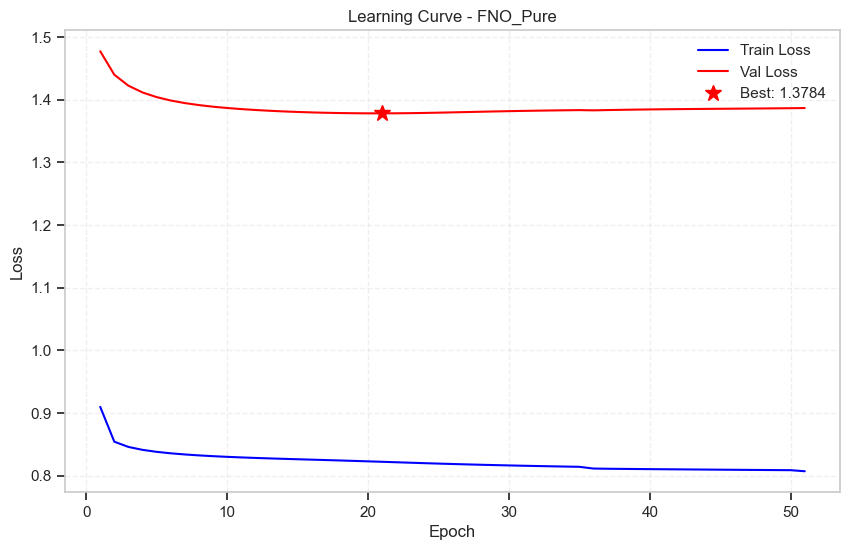

Generating predictions for FNO_Pure in BASIC...
Predicting batch 1/33, shape: (1, 60, 5, 5, 12)
Predicting batch 2/33, shape: (1, 60, 5, 5, 12)
Predicting batch 3/33, shape: (1, 60, 5, 5, 12)
Predicting batch 4/33, shape: (1, 60, 5, 5, 12)
Predicting batch 5/33, shape: (1, 60, 5, 5, 12)
Predicting batch 6/33, shape: (1, 60, 5, 5, 12)
Predicting batch 7/33, shape: (1, 60, 5, 5, 12)
Predicting batch 8/33, shape: (1, 60, 5, 5, 12)
Predicting batch 9/33, shape: (1, 60, 5, 5, 12)
Predicting batch 10/33, shape: (1, 60, 5, 5, 12)
Predicting batch 11/33, shape: (1, 60, 5, 5, 12)
Predicting batch 12/33, shape: (1, 60, 5, 5, 12)
Predicting batch 13/33, shape: (1, 60, 5, 5, 12)
Predicting batch 14/33, shape: (1, 60, 5, 5, 12)
Predicting batch 15/33, shape: (1, 60, 5, 5, 12)
Predicting batch 16/33, shape: (1, 60, 5, 5, 12)
Predicting batch 17/33, shape: (1, 60, 5, 5, 12)
Predicting batch 18/33, shape: (1, 60, 5, 5, 12)
Predicting batch 19/33, shape: (1, 60, 5, 5, 12)
Predicting batch 20/33, shape:

Model: "FNO_ConvLSTM_Hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_fno_lstm      │ (None, 60, 5, 5,  │          0 │ -                 │
│ (InputLayer)        │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merge_bt (Lambda)   │ (None, 5, 5, 15)  │          0 │ input_fno_lstm[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno1_dw             │ (None, 5, 5, 15)  │        390 │ merge_bt[0][0]    │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno1_pw (Conv2D)    │ (None, 5, 5, 32)  │        512 │ fno1_dw[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno1_skip (Conv2D)  │ (None, 5, 5, 32)  │        512 │ merge_bt[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno1_res (Add)      │ (None, 5, 5, 32)  │          0 │ fno1_pw[0][0],    │
│                     │                   │            │ fno1_skip[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno1_ln             │ (None, 5, 5, 32)  │         64 │ fno1_res[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno2_dw             │ (None, 5, 5, 32)  │        832 │ fno1_ln[0][0]     │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno2_pw (Conv2D)    │ (None, 5, 5, 32)  │      1,056 │ fno2_dw[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno2_skip (Conv2D)  │ (None, 5, 5, 32)  │      1,056 │ fno1_ln[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno2_res (Add)      │ (None, 5, 5, 32)  │          0 │ fno2_pw[0][0],    │
│                     │                   │            │ fno2_skip[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno2_ln             │ (None, 5, 5, 32)  │         64 │ fno2_res[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ unmerge_bt (Lambda) │ (None, 60, 5, 5,  │          0 │ fno2_ln[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convlstm_dec1       │ (None, 60, 5, 5,  │     73,856 │ unmerge_bt[0][0]  │
│ (ConvLSTM2D)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convlstm_dec2       │ (None, 5, 5, 16)  │     27,712 │ convlstm_dec1[0]… │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 5, 5, 16)  │        272 │ convlstm_dec2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 5, 5, 16)  │         32 │ conv2d[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_conv (Conv2D)  │ (None, 5, 5, 12)  │        204 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 12, 5, 5)  │          0 │ head_conv[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 106,562 (416.26 KB)

 Trainable params: 106,562 (416.26 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for FNO_ConvLSTM_Hybrid in KCE with batch_size=1...

Epoch 1: val_loss improved from None to 1.29909, saving model to d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V3_FNO_Models\h12\KCE\training_metrics\FNO_ConvLSTM_Hybrid_best_h12.weights.h5
KCE - FNO_ConvLSTM_Hybrid | Epoch 1 | Loss: 0.9538 | Val Loss: 1.2991 | LR: 1.00e-03 | Elapsed: 41s

Epoch 2: val_loss improved from 1.29909 to 1.16485, saving model to d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V3_FNO_Models\h12\KCE\training_metrics\FNO_ConvLSTM_Hybrid_best_h12.weights.h5
KCE - FNO_ConvLSTM_Hybrid | Epoch 2 | Loss: 0.7757 | Val Loss: 1.1649 | LR: 1.00e-03 | Elapsed: 76s

Epoch 3: val_loss improved from 1.16485 to 1.12615, saving model to d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V3_FNO_Models\h12\KCE\training_metrics\FNO_ConvLSTM_Hybrid_best_h12.weights.h5
KCE - FNO_ConvLSTM_Hybrid | Epoch 3 | Loss: 0.7433 | Val Loss: 1.1262 | LR: 1.00e-

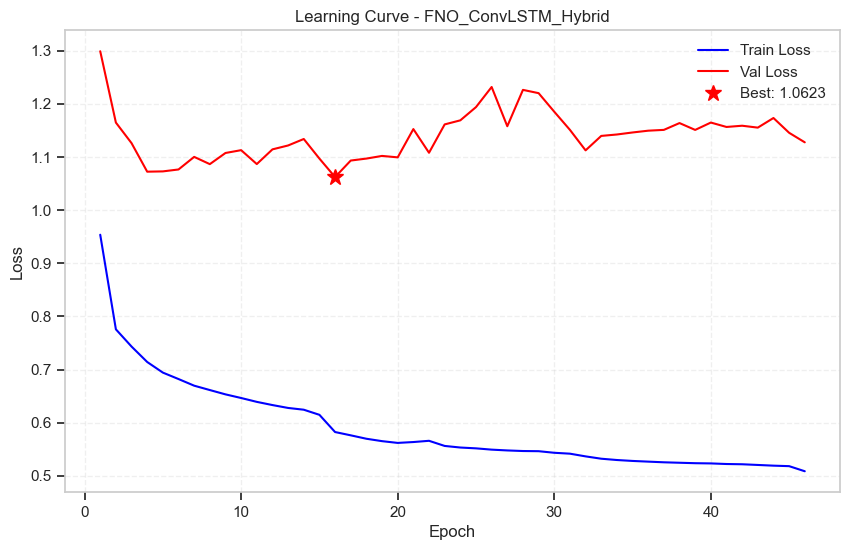

Generating predictions for FNO_ConvLSTM_Hybrid in KCE...
Predicting batch 1/33, shape: (1, 60, 5, 5, 15)
Predicting batch 2/33, shape: (1, 60, 5, 5, 15)
Predicting batch 3/33, shape: (1, 60, 5, 5, 15)
Predicting batch 4/33, shape: (1, 60, 5, 5, 15)
Predicting batch 5/33, shape: (1, 60, 5, 5, 15)
Predicting batch 6/33, shape: (1, 60, 5, 5, 15)
Predicting batch 7/33, shape: (1, 60, 5, 5, 15)
Predicting batch 8/33, shape: (1, 60, 5, 5, 15)
Predicting batch 9/33, shape: (1, 60, 5, 5, 15)
Predicting batch 10/33, shape: (1, 60, 5, 5, 15)
Predicting batch 11/33, shape: (1, 60, 5, 5, 15)
Predicting batch 12/33, shape: (1, 60, 5, 5, 15)
Predicting batch 13/33, shape: (1, 60, 5, 5, 15)
Predicting batch 14/33, shape: (1, 60, 5, 5, 15)
Predicting batch 15/33, shape: (1, 60, 5, 5, 15)
Predicting batch 16/33, shape: (1, 60, 5, 5, 15)
Predicting batch 17/33, shape: (1, 60, 5, 5, 15)
Predicting batch 18/33, shape: (1, 60, 5, 5, 15)
Predicting batch 19/33, shape: (1, 60, 5, 5, 15)
Predicting batch 20/3

Model: "FNO_Pure"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_fno_pure      │ (None, 60, 5, 5,  │          0 │ -                 │
│ (InputLayer)        │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merge_bt_pure       │ (None, 5, 5, 15)  │          0 │ input_fno_pure[0… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno_p1_dw           │ (None, 5, 5, 15)  │        390 │ merge_bt_pure[0]… │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno_p1_pw (Conv2D)  │ (None, 5, 5, 32)  │        512 │ fno_p1_dw[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno_p1_skip         │ (None, 5, 5, 32)  │        512 │ merge_bt_pure[0]… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno_p1_res (Add)    │ (None, 5, 5, 32)  │          0 │ fno_p1_pw[0][0],  │
│                     │                   │            │ fno_p1_skip[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno_p1_ln           │ (None, 5, 5, 32)  │         64 │ fno_p1_res[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno_p2_dw           │ (None, 5, 5, 32)  │        832 │ fno_p1_ln[0][0]   │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno_p2_pw (Conv2D)  │ (None, 5, 5, 32)  │      1,056 │ fno_p2_dw[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno_p2_skip         │ (None, 5, 5, 32)  │      1,056 │ fno_p1_ln[0][0]   │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno_p2_res (Add)    │ (None, 5, 5, 32)  │          0 │ fno_p2_pw[0][0],  │
│                     │                   │            │ fno_p2_skip[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno_p2_ln           │ (None, 5, 5, 32)  │         64 │ fno_p2_res[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 5, 5, 12)  │        396 │ fno_p2_ln[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ unmerge_bt_pure     │ (None, 60, 5, 5,  │          0 │ conv2d[0][0]      │
│ (Lambda)            │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ temporal_avg        │ (None, 5, 5, 12)  │          0 │ unmerge_bt_pure[… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 12, 5, 5)  │          0 │ temporal_avg[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_channel         │ (None, 12, 5, 5,  │          0 │ permute[0][0]     │
│ (Lambda)            │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,882 (19.07 KB)

 Trainable params: 4,882 (19.07 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for FNO_Pure in KCE with batch_size=1...

Epoch 1: val_loss improved from None to 1.50727, saving model to d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V3_FNO_Models\h12\KCE\training_metrics\FNO_Pure_best_h12.weights.h5
KCE - FNO_Pure | Epoch 1 | Loss: 0.9761 | Val Loss: 1.5073 | LR: 1.00e-03 | Elapsed: 8s

Epoch 2: val_loss improved from 1.50727 to 1.47644, saving model to d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V3_FNO_Models\h12\KCE\training_metrics\FNO_Pure_best_h12.weights.h5
KCE - FNO_Pure | Epoch 2 | Loss: 0.9552 | Val Loss: 1.4764 | LR: 1.00e-03 | Elapsed: 13s

Epoch 3: val_loss improved from 1.47644 to 1.46444, saving model to d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V3_FNO_Models\h12\KCE\training_metrics\FNO_Pure_best_h12.weights.h5
KCE - FNO_Pure | Epoch 3 | Loss: 0.9401 | Val Loss: 1.4644 | LR: 1.00e-03 | Elapsed: 18s

Epoch 4: val_loss improved from 1.46444 to 1.46116, saving 

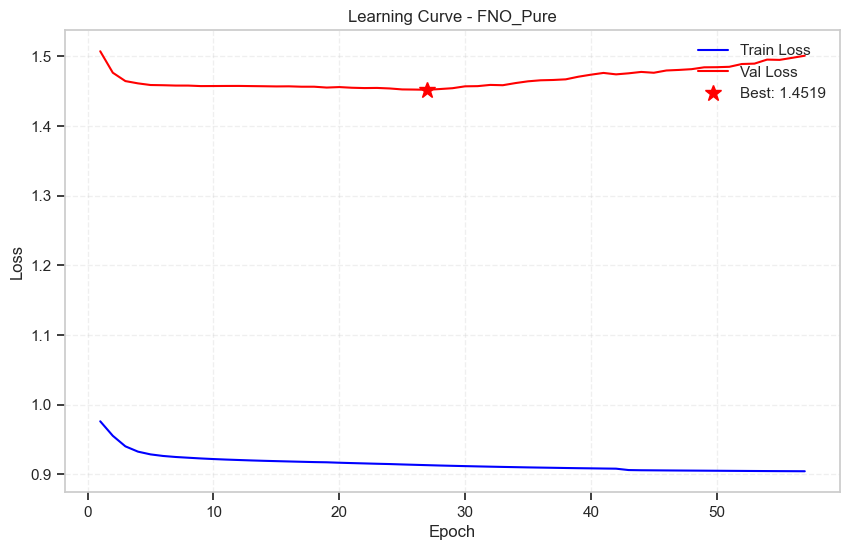

Generating predictions for FNO_Pure in KCE...
Predicting batch 1/33, shape: (1, 60, 5, 5, 15)
Predicting batch 2/33, shape: (1, 60, 5, 5, 15)
Predicting batch 3/33, shape: (1, 60, 5, 5, 15)
Predicting batch 4/33, shape: (1, 60, 5, 5, 15)
Predicting batch 5/33, shape: (1, 60, 5, 5, 15)
Predicting batch 6/33, shape: (1, 60, 5, 5, 15)
Predicting batch 7/33, shape: (1, 60, 5, 5, 15)
Predicting batch 8/33, shape: (1, 60, 5, 5, 15)
Predicting batch 9/33, shape: (1, 60, 5, 5, 15)
Predicting batch 10/33, shape: (1, 60, 5, 5, 15)
Predicting batch 11/33, shape: (1, 60, 5, 5, 15)
Predicting batch 12/33, shape: (1, 60, 5, 5, 15)
Predicting batch 13/33, shape: (1, 60, 5, 5, 15)
Predicting batch 14/33, shape: (1, 60, 5, 5, 15)
Predicting batch 15/33, shape: (1, 60, 5, 5, 15)
Predicting batch 16/33, shape: (1, 60, 5, 5, 15)
Predicting batch 17/33, shape: (1, 60, 5, 5, 15)
Predicting batch 18/33, shape: (1, 60, 5, 5, 15)
Predicting batch 19/33, shape: (1, 60, 5, 5, 15)
Predicting batch 20/33, shape: (

Model: "FNO_ConvLSTM_Hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_fno_lstm      │ (None, 60, 5, 5,  │          0 │ -                 │
│ (InputLayer)        │ 18)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merge_bt (Lambda)   │ (None, 5, 5, 18)  │          0 │ input_fno_lstm[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno1_dw             │ (None, 5, 5, 18)  │        468 │ merge_bt[0][0]    │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno1_pw (Conv2D)    │ (None, 5, 5, 32)  │        608 │ fno1_dw[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno1_skip (Conv2D)  │ (None, 5, 5, 32)  │        608 │ merge_bt[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno1_res (Add)      │ (None, 5, 5, 32)  │          0 │ fno1_pw[0][0],    │
│                     │                   │            │ fno1_skip[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno1_ln             │ (None, 5, 5, 32)  │         64 │ fno1_res[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno2_dw             │ (None, 5, 5, 32)  │        832 │ fno1_ln[0][0]     │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno2_pw (Conv2D)    │ (None, 5, 5, 32)  │      1,056 │ fno2_dw[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno2_skip (Conv2D)  │ (None, 5, 5, 32)  │      1,056 │ fno1_ln[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno2_res (Add)      │ (None, 5, 5, 32)  │          0 │ fno2_pw[0][0],    │
│                     │                   │            │ fno2_skip[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno2_ln             │ (None, 5, 5, 32)  │         64 │ fno2_res[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ unmerge_bt (Lambda) │ (None, 60, 5, 5,  │          0 │ fno2_ln[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convlstm_dec1       │ (None, 60, 5, 5,  │     73,856 │ unmerge_bt[0][0]  │
│ (ConvLSTM2D)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convlstm_dec2       │ (None, 5, 5, 16)  │     27,712 │ convlstm_dec1[0]… │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 5, 5, 16)  │        272 │ convlstm_dec2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 5, 5, 16)  │         32 │ conv2d[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_conv (Conv2D)  │ (None, 5, 5, 12)  │        204 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 12, 5, 5)  │          0 │ head_conv[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 106,832 (417.31 KB)

 Trainable params: 106,832 (417.31 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for FNO_ConvLSTM_Hybrid in PAFC with batch_size=1...

Epoch 1: val_loss improved from None to 1.21589, saving model to d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V3_FNO_Models\h12\PAFC\training_metrics\FNO_ConvLSTM_Hybrid_best_h12.weights.h5
PAFC - FNO_ConvLSTM_Hybrid | Epoch 1 | Loss: 0.9171 | Val Loss: 1.2159 | LR: 1.00e-03 | Elapsed: 46s

Epoch 2: val_loss improved from 1.21589 to 1.13983, saving model to d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V3_FNO_Models\h12\PAFC\training_metrics\FNO_ConvLSTM_Hybrid_best_h12.weights.h5
PAFC - FNO_ConvLSTM_Hybrid | Epoch 2 | Loss: 0.7446 | Val Loss: 1.1398 | LR: 1.00e-03 | Elapsed: 84s

Epoch 3: val_loss improved from 1.13983 to 1.13859, saving model to d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V3_FNO_Models\h12\PAFC\training_metrics\FNO_ConvLSTM_Hybrid_best_h12.weights.h5
PAFC - FNO_ConvLSTM_Hybrid | Epoch 3 | Loss: 0.7126 | Val Loss: 1.1386 | LR:

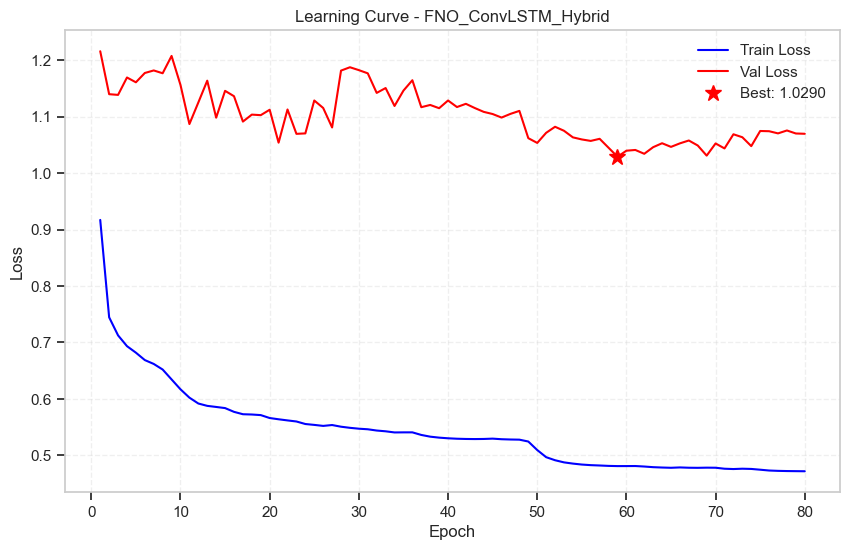

Generating predictions for FNO_ConvLSTM_Hybrid in PAFC...
Predicting batch 1/33, shape: (1, 60, 5, 5, 18)
Predicting batch 2/33, shape: (1, 60, 5, 5, 18)
Predicting batch 3/33, shape: (1, 60, 5, 5, 18)
Predicting batch 4/33, shape: (1, 60, 5, 5, 18)
Predicting batch 5/33, shape: (1, 60, 5, 5, 18)
Predicting batch 6/33, shape: (1, 60, 5, 5, 18)
Predicting batch 7/33, shape: (1, 60, 5, 5, 18)
Predicting batch 8/33, shape: (1, 60, 5, 5, 18)
Predicting batch 9/33, shape: (1, 60, 5, 5, 18)
Predicting batch 10/33, shape: (1, 60, 5, 5, 18)
Predicting batch 11/33, shape: (1, 60, 5, 5, 18)
Predicting batch 12/33, shape: (1, 60, 5, 5, 18)
Predicting batch 13/33, shape: (1, 60, 5, 5, 18)
Predicting batch 14/33, shape: (1, 60, 5, 5, 18)
Predicting batch 15/33, shape: (1, 60, 5, 5, 18)
Predicting batch 16/33, shape: (1, 60, 5, 5, 18)
Predicting batch 17/33, shape: (1, 60, 5, 5, 18)
Predicting batch 18/33, shape: (1, 60, 5, 5, 18)
Predicting batch 19/33, shape: (1, 60, 5, 5, 18)
Predicting batch 20/

Model: "FNO_Pure"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_fno_pure      │ (None, 60, 5, 5,  │          0 │ -                 │
│ (InputLayer)        │ 18)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merge_bt_pure       │ (None, 5, 5, 18)  │          0 │ input_fno_pure[0… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno_p1_dw           │ (None, 5, 5, 18)  │        468 │ merge_bt_pure[0]… │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno_p1_pw (Conv2D)  │ (None, 5, 5, 32)  │        608 │ fno_p1_dw[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno_p1_skip         │ (None, 5, 5, 32)  │        608 │ merge_bt_pure[0]… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno_p1_res (Add)    │ (None, 5, 5, 32)  │          0 │ fno_p1_pw[0][0],  │
│                     │                   │            │ fno_p1_skip[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno_p1_ln           │ (None, 5, 5, 32)  │         64 │ fno_p1_res[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno_p2_dw           │ (None, 5, 5, 32)  │        832 │ fno_p1_ln[0][0]   │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno_p2_pw (Conv2D)  │ (None, 5, 5, 32)  │      1,056 │ fno_p2_dw[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno_p2_skip         │ (None, 5, 5, 32)  │      1,056 │ fno_p1_ln[0][0]   │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno_p2_res (Add)    │ (None, 5, 5, 32)  │          0 │ fno_p2_pw[0][0],  │
│                     │                   │            │ fno_p2_skip[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fno_p2_ln           │ (None, 5, 5, 32)  │         64 │ fno_p2_res[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 5, 5, 12)  │        396 │ fno_p2_ln[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ unmerge_bt_pure     │ (None, 60, 5, 5,  │          0 │ conv2d[0][0]      │
│ (Lambda)            │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ temporal_avg        │ (None, 5, 5, 12)  │          0 │ unmerge_bt_pure[… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 12, 5, 5)  │          0 │ temporal_avg[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_channel         │ (None, 12, 5, 5,  │          0 │ permute[0][0]     │
│ (Lambda)            │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,152 (20.12 KB)

 Trainable params: 5,152 (20.12 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for FNO_Pure in PAFC with batch_size=1...

Epoch 1: val_loss improved from None to 1.52895, saving model to d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V3_FNO_Models\h12\PAFC\training_metrics\FNO_Pure_best_h12.weights.h5
PAFC - FNO_Pure | Epoch 1 | Loss: 0.9917 | Val Loss: 1.5289 | LR: 1.00e-03 | Elapsed: 9s

Epoch 2: val_loss improved from 1.52895 to 1.48556, saving model to d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V3_FNO_Models\h12\PAFC\training_metrics\FNO_Pure_best_h12.weights.h5
PAFC - FNO_Pure | Epoch 2 | Loss: 0.9590 | Val Loss: 1.4856 | LR: 1.00e-03 | Elapsed: 15s

Epoch 3: val_loss improved from 1.48556 to 1.47196, saving model to d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V3_FNO_Models\h12\PAFC\training_metrics\FNO_Pure_best_h12.weights.h5
PAFC - FNO_Pure | Epoch 3 | Loss: 0.9432 | Val Loss: 1.4720 | LR: 1.00e-03 | Elapsed: 21s

Epoch 4: val_loss improved from 1.47196 to 1.46298, 

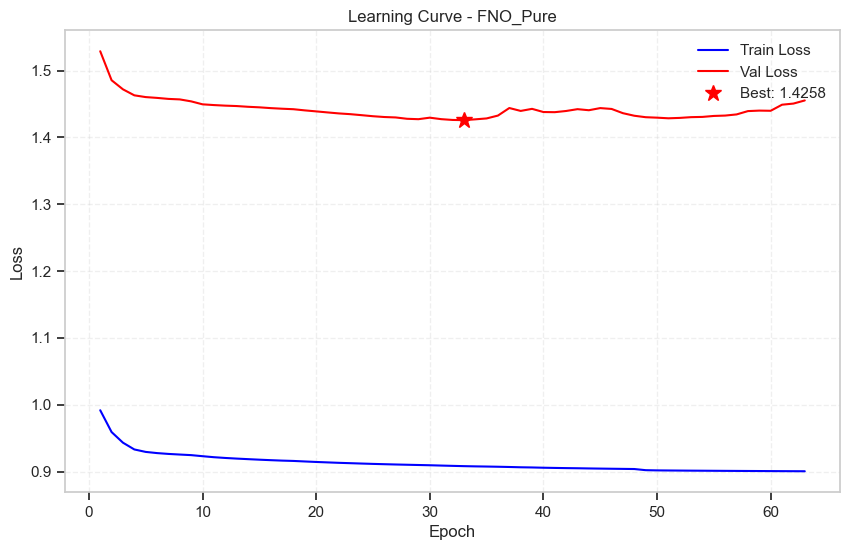

Generating predictions for FNO_Pure in PAFC...
Predicting batch 1/33, shape: (1, 60, 5, 5, 18)
Predicting batch 2/33, shape: (1, 60, 5, 5, 18)
Predicting batch 3/33, shape: (1, 60, 5, 5, 18)
Predicting batch 4/33, shape: (1, 60, 5, 5, 18)
Predicting batch 5/33, shape: (1, 60, 5, 5, 18)
Predicting batch 6/33, shape: (1, 60, 5, 5, 18)
Predicting batch 7/33, shape: (1, 60, 5, 5, 18)
Predicting batch 8/33, shape: (1, 60, 5, 5, 18)
Predicting batch 9/33, shape: (1, 60, 5, 5, 18)
Predicting batch 10/33, shape: (1, 60, 5, 5, 18)
Predicting batch 11/33, shape: (1, 60, 5, 5, 18)
Predicting batch 12/33, shape: (1, 60, 5, 5, 18)
Predicting batch 13/33, shape: (1, 60, 5, 5, 18)
Predicting batch 14/33, shape: (1, 60, 5, 5, 18)
Predicting batch 15/33, shape: (1, 60, 5, 5, 18)
Predicting batch 16/33, shape: (1, 60, 5, 5, 18)
Predicting batch 17/33, shape: (1, 60, 5, 5, 18)
Predicting batch 18/33, shape: (1, 60, 5, 5, 18)
Predicting batch 19/33, shape: (1, 60, 5, 5, 18)
Predicting batch 20/33, shape: 

0

In [11]:

# Training loop
results = []
all_histories = {}
for horizon in CONFIG['enabled_horizons']:
    print(f'=== Running experiments for horizon H={horizon} months ===')
    data_splits_h = preprocess_data(ds, CONFIG, lat, lon, horizon)
    for exp_name in CONFIG['feature_sets']:
        try:
            X_tr, y_tr, X_va, y_va, scaler = data_splits_h[exp_name]
            print(f"{exp_name}: X_tr={X_tr.shape}, y_tr={y_tr.shape}, X_va={X_va.shape}, y_va={y_va.shape}")
        except KeyError as e:
            print(f"Error accessing data for experiment {exp_name}: {e}")
            continue

        out_exp = CONFIG['out_root'] / exp_name
        out_exp.mkdir(exist_ok=True)

        for model_name, model_builder in MODELS.items():
            try:
                tf.keras.backend.clear_session()
                num_features = len(CONFIG['feature_sets'][exp_name])
                print(f"Building {model_name} with {num_features} features, lat={lat}, lon={lon}, horizon={horizon}")
                model = model_builder(num_features, lat, lon, horizon)
                model, history = train_model(model, X_tr, y_tr, X_va, y_va, CONFIG, model_name, exp_name, CONFIG['out_root'], horizon)
                all_histories[f"{exp_name}_{model_name}_H{horizon}"] = history

                if not history or not history.get('val_loss'):
                    print(f"Skipping predictions for {model_name} in {exp_name} due to training failure.")
                    continue

                print(f"Generating predictions for {model_name} in {exp_name}...")
                try:
                    prediction_batch = max(1, CONFIG.get('prediction_batch_size') or max(1, CONFIG['batch_size']//2))
                    y_hat_sc = batch_predict(model, X_va, batch_size=prediction_batch)
                    if y_hat_sc.shape != y_va.shape:
                        y_hat_sc = y_hat_sc.reshape(y_va.shape)
                    y_hat = scaler.inverse_transform(y_hat_sc.reshape(-1, 1)).reshape(y_va.shape)
                    y_true = scaler.inverse_transform(y_va.reshape(-1, 1)).reshape(y_va.shape)
                    scale_ratio = float(np.nanmax(np.abs(y_hat)) / (np.nanmax(np.abs(y_true)) + 1e-8))
                    if scale_ratio > 50.0:
                        print(f"[WARN] {exp_name} - {model_name}: prediction scale ratio {scale_ratio:.1f}x, skipping metric export.")
                        continue
                except Exception as e:
                    print(f"Error generating predictions for {model_name} in {exp_name}: {e}")
                    continue

                for h in range(horizon):
                    try:
                        y_true_h = y_true[:, h, ..., 0]
                        y_pred_h = y_hat[:, h, ..., 0]
                        rmse = np.sqrt(mean_squared_error(y_true_h.ravel(), y_pred_h.ravel()))
                        mae = mean_absolute_error(y_true_h.ravel(), y_pred_h.ravel())
                        r2 = r2_score(y_true_h.ravel(), y_pred_h.ravel())
                        mean_true = float(np.mean(y_true_h))
                        mean_pred = float(np.mean(y_pred_h))
                        total_true = float(np.sum(y_true_h))
                        total_pred = float(np.sum(y_pred_h))
                        bias = abs(mean_pred - mean_true) / (abs(mean_true) + 1e-8)
                        if bias > 0.10:
                            print(f"[BIAS] {exp_name} - {model_name} - H{h+1}: mean bias {bias*100:.1f}%")
                        results.append({
                            'TotalHorizon': horizon,
                            'Experiment': exp_name,
                            'Model': model_name,
                            'H': h + 1,
                            'RMSE': rmse,
                            'MAE': mae,
                            'R^2': r2,
                            'Mean_True_mm': mean_true,
                            'Mean_Pred_mm': mean_pred,
                            'TotalPrecipitation': total_true,
                            'TotalPrecipitation_Pred': total_pred
                        })
                        print(f"    H={h+1}: RMSE={rmse:.4f}, MAE={mae:.4f}, R^2={r2:.4f}")
                    except Exception as e:
                        print(f"Error evaluating predictions for {model_name}, horizon {h+1}: {e}")

                tf.keras.backend.clear_session()
                gc.collect()
            except Exception as e:
                print(f"Error training {model_name} for {exp_name}: {e}")
                continue

if results:
    try:
        res_df = pd.DataFrame(results)
        horizon_label = 'multi' if len(CONFIG['enabled_horizons']) > 1 else str(CONFIG['enabled_horizons'][0])
        out_csv = CONFIG['out_root'] / f'metrics_spatial_v2_refactored_h{horizon_label}.csv'
        res_df.to_csv(out_csv, index=False)
        print(f'Results saved to {out_csv}')
        res_df['mean_bias_pct'] = 100 * (res_df['Mean_Pred_mm'] - res_df['Mean_True_mm']) / (res_df['Mean_True_mm'].replace(0, np.nan))
        flagged = res_df[res_df['mean_bias_pct'].abs() > 10]
        if not flagged.empty:
            print('[BIAS] The following experiment/model horizons exceeded the 10% mean bias threshold:')
            print(flagged[['Experiment', 'Model', 'H', 'mean_bias_pct']])
    except Exception as e:
        print(f"Error saving results: {e}")
else:
    print("No results generated; skipping CSV export")

# Aggressive cleanup
tf.keras.backend.clear_session()
gc.collect()

Shape files loaded for visualization
Plotting comparisons for H=12


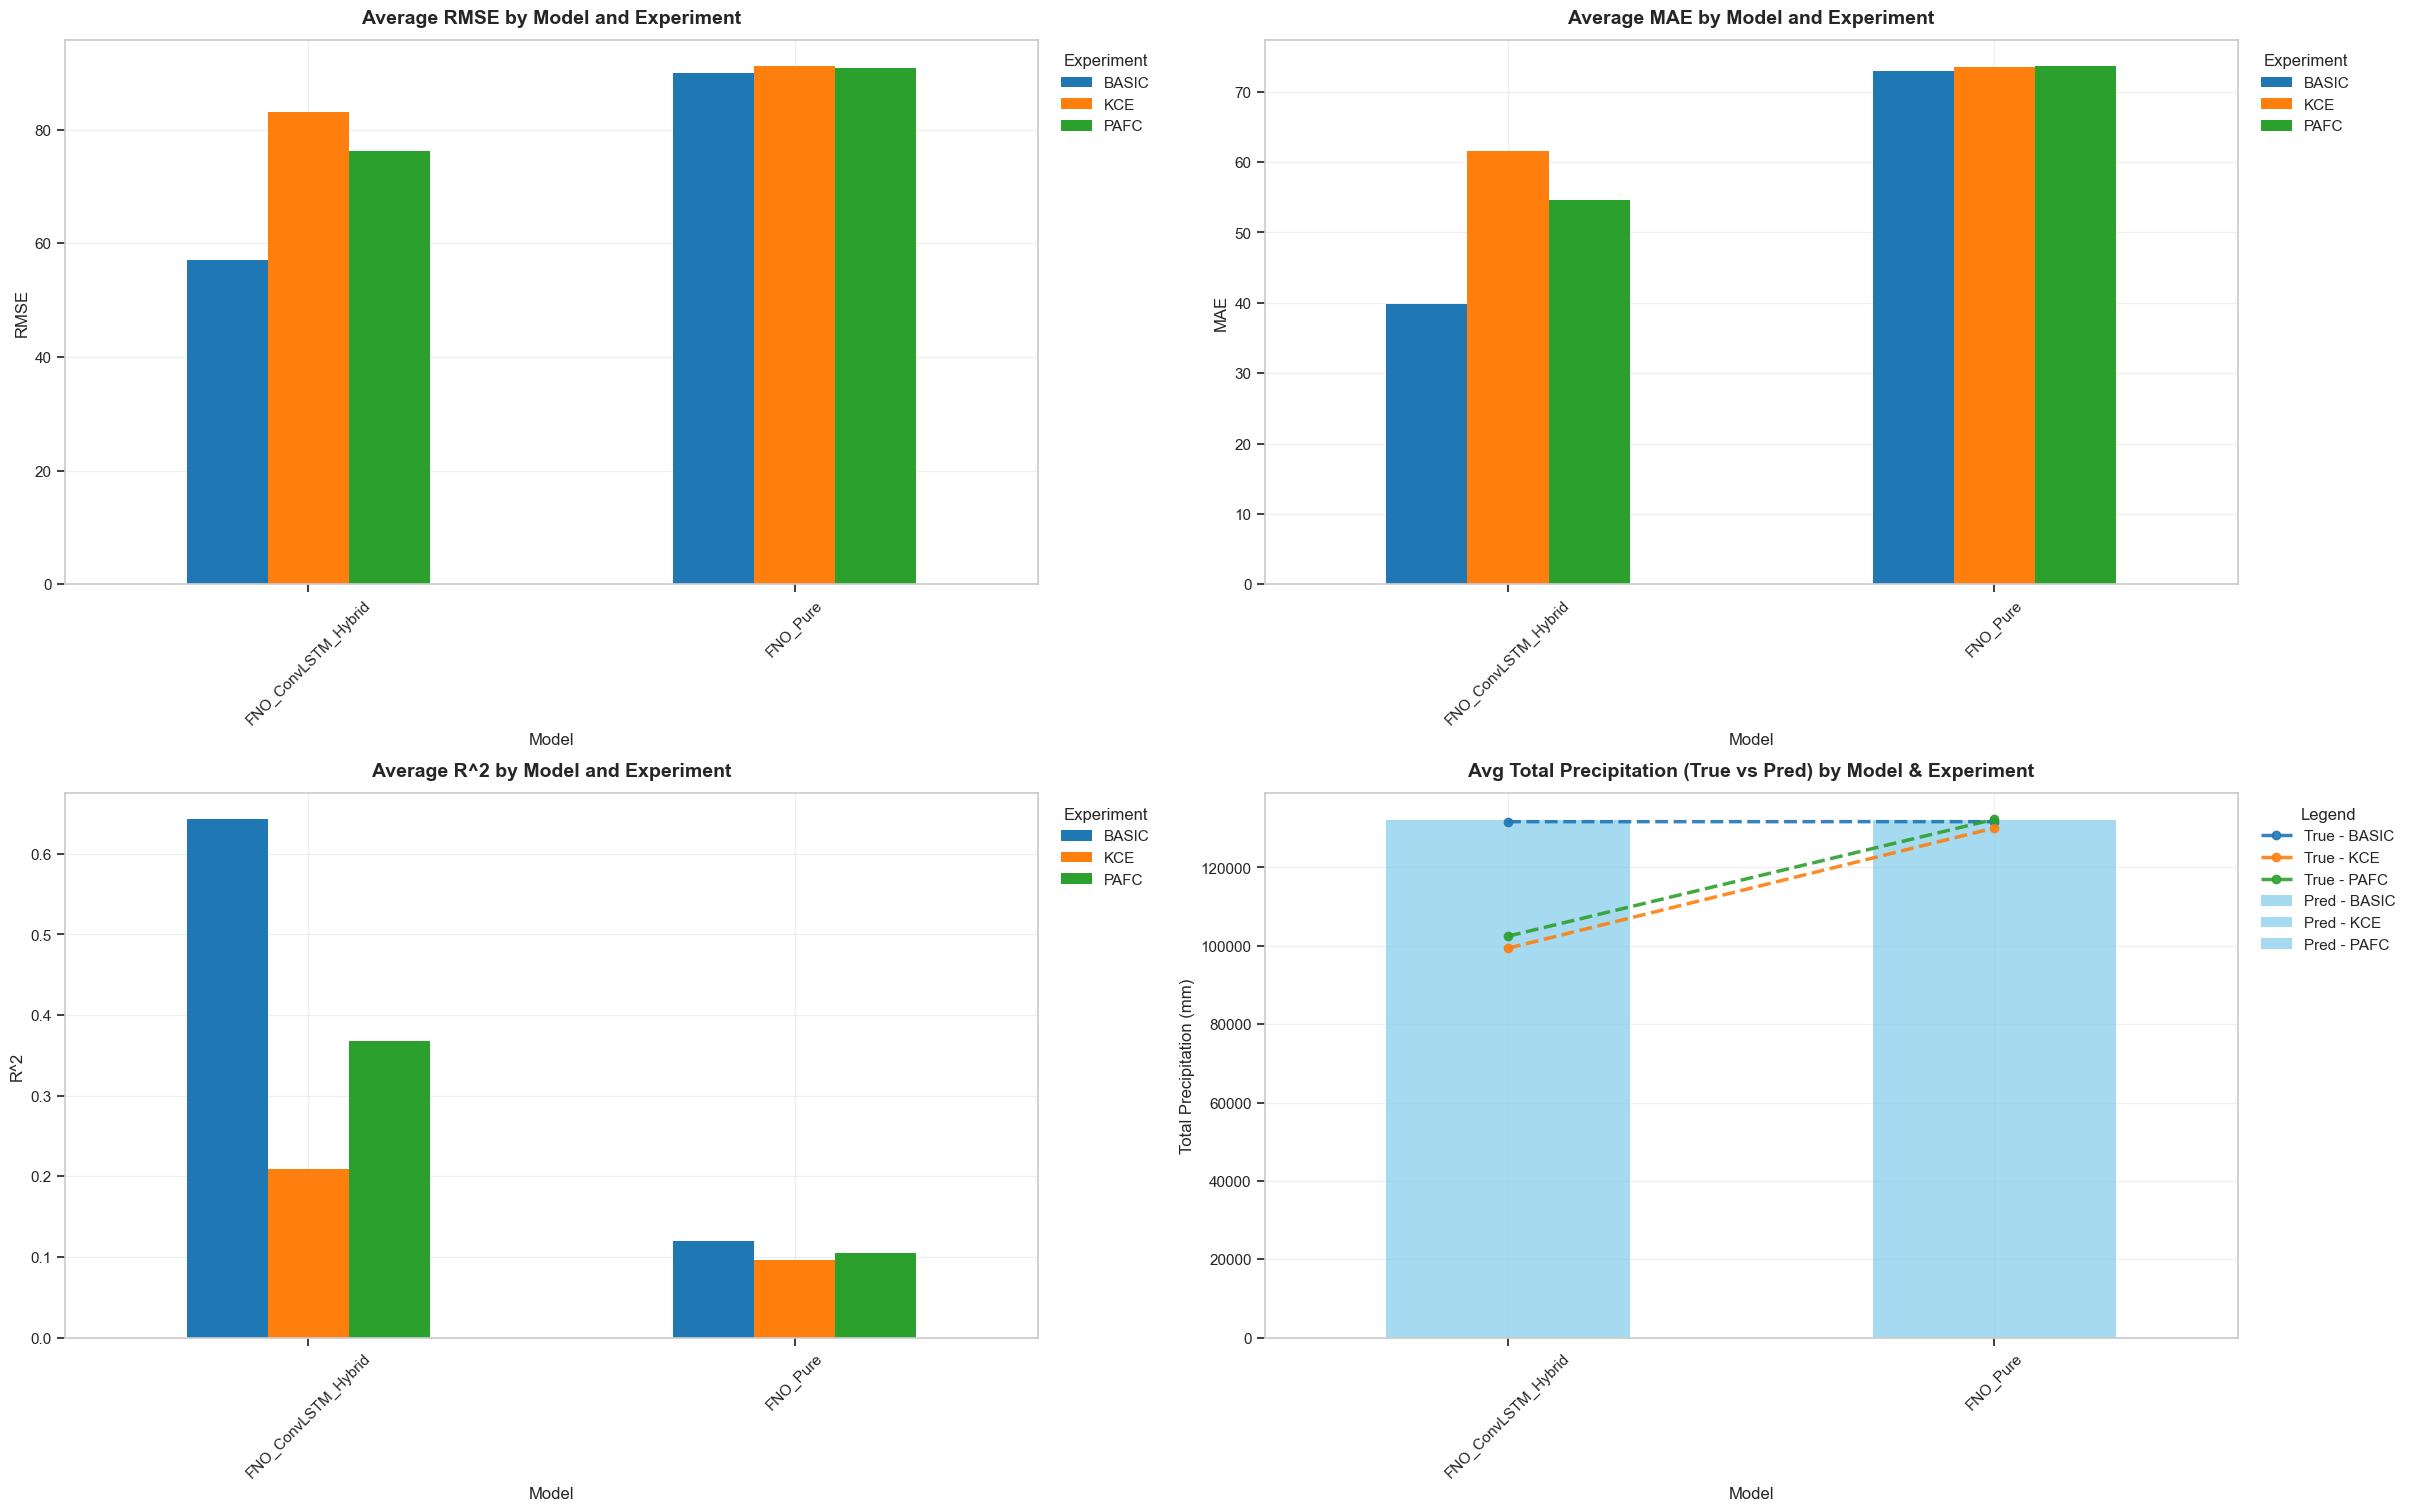

Metrics plot saved (per horizon) at: d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V3_FNO_Models\comparisons\metrics_comparison_h{TH}.png

 SUMMARY TABLE BEST MODELS BY EXPERIMENT:
------------------------------------------------------------
                          Model       RMSE        MAE       R^2  TotalPrecipitation  TotalPrecipitation_Pred
Experiment                                                                                                  
BASIC       FNO_ConvLSTM_Hybrid  52.232377  36.303108  0.700160       127743.429688            123001.921875
KCE         FNO_ConvLSTM_Hybrid  65.160177  45.812794  0.533291       130168.617188            119183.054688
PAFC        FNO_ConvLSTM_Hybrid  69.444029  51.386253  0.469907       130168.617188            103803.875000


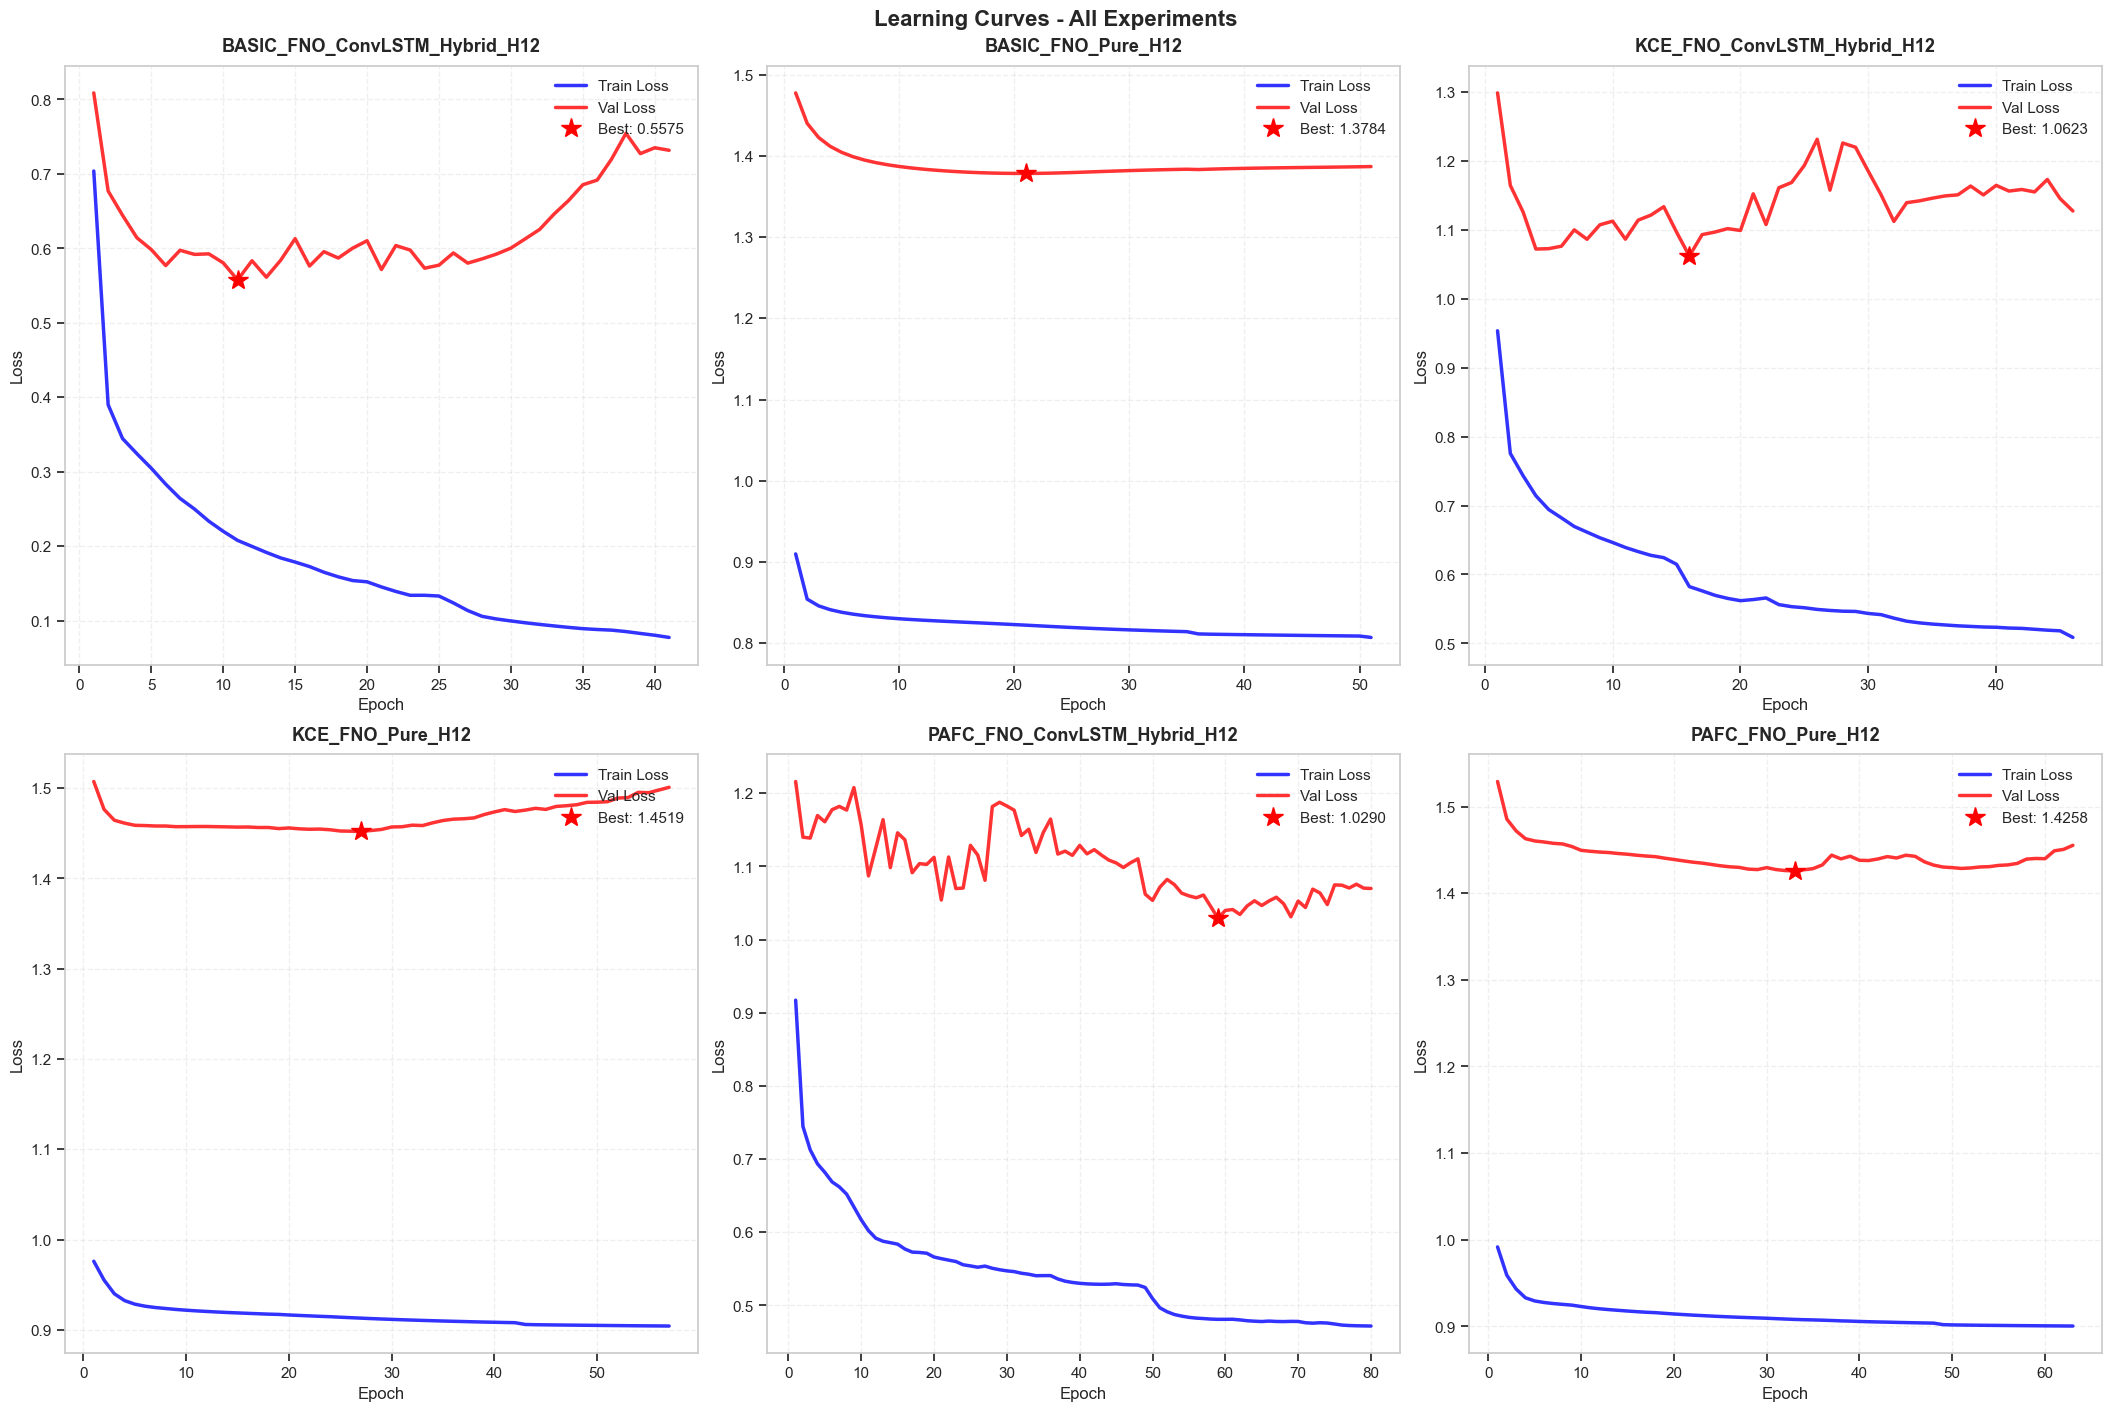

TRAINING SUMMARY:


In [12]:
# ==================================================
# VISUALIZATION AND COMPARISON
# ==================================================

def quick_plot(ax, data, cmap, title, vmin=None, vmax=None, unit=None):
    """Plot spatial data with optional Cartopy support."""
    if CARTOPY_AVAILABLE and ccrs is not None:
        mesh = ax.pcolormesh(ds.longitude, ds.latitude, data, cmap=cmap, shading='nearest',
                             vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
        ax.coastlines()
        if gpd is not None and DEPT_GDF is not None:
            ax.add_geometries(DEPT_GDF.geometry, ccrs.PlateCarree(),
                              edgecolor='black', facecolor='none', linewidth=1)
        ax.gridlines(draw_labels=False, linewidth=0.5, linestyle='--', alpha=0.4)
    else:
        mesh = ax.pcolormesh(ds.longitude, ds.latitude, data, cmap=cmap, shading='nearest',
                             vmin=vmin, vmax=vmax)
        ax.set_xlabel('Longitude', fontsize=11)
        ax.set_ylabel('Latitude', fontsize=11)
    ax.set_title(title, fontsize=9, pad=15)
    return mesh

# Load shapefiles if available
DEPT_GDF = None
if gpd is not None:
    shape_dir = CONFIG['base_path'] / 'data' / 'input' / 'shapes'
    if shape_dir.exists():
        DEPT_GDF = gpd.read_file(shape_dir / 'MGN_Departamento.shp')
        print("Shape files loaded for visualization")

# Generate visualizations
comp_dir = CONFIG['out_root'] / 'comparisons'
comp_dir.mkdir(exist_ok=True)

# Ensure res_df exists and is non-empty before using it.
# Initialize res_df_local from res_df and then overwrite per-horizon as before.
if 'res_df' in globals() and not res_df.empty:
    res_df_local = res_df.copy()
    for TH in sorted(res_df['TotalHorizon'].unique()):
        sub_df = res_df[res_df['TotalHorizon'] == TH]
        print(f'Plotting comparisons for H={TH}')
        res_df_local = sub_df
    # Metrics comparison plot
    fig, axes = plt.subplots(2, 2, figsize=(24, 15), constrained_layout=True)
    # FIX: Changed 'R²' to 'R^2' to match the DataFrame column name
    for metric, ax in zip(['RMSE', 'MAE', 'R^2', 'TotalPrecipitation'], axes.ravel()):
        if metric != 'TotalPrecipitation':
            pivot = res_df_local.pivot_table(values=metric, index='Model', columns='Experiment', aggfunc='mean')
            pivot.plot(kind='bar', ax=ax)
            ax.set_title(f'Average {metric} by Model and Experiment', pad=12, fontsize=14, weight='bold')
            ax.set_ylabel(metric)
            ax.set_xlabel('Model')
            ax.legend(title='Experiment', bbox_to_anchor=(1.01, 1), loc='upper left')
            ax.grid(alpha=0.3)
            ax.tick_params(axis='x', rotation=45)
        else:
            pivot_true = res_df_local.pivot_table(values='TotalPrecipitation', index='Model', columns='Experiment', aggfunc='mean')
            pivot_pred = res_df_local.pivot_table(values='TotalPrecipitation_Pred', index='Model', columns='Experiment', aggfunc='mean')
            pivot_true.plot(kind='bar', ax=ax, color='skyblue', alpha=0.75)
            pivot_pred.plot(kind='line', ax=ax, marker='o', linestyle='--', linewidth=2.5, alpha=0.9)
            ax.set_title('Avg Total Precipitation (True vs Pred) by Model & Experiment', pad=12, fontsize=14, weight='bold')
            ax.set_ylabel('Total Precipitation (mm)')
            ax.set_xlabel('Model')
            legend_labels = [f'True - {c}' for c in pivot_true.columns] + [f'Pred - {c}' for c in pivot_pred.columns]
            ax.legend(legend_labels, title='Legend', bbox_to_anchor=(1.01, 1), loc='upper left')
            ax.grid(alpha=0.3)
            ax.tick_params(axis='x', rotation=45)

    fig.subplots_adjust(wspace=0.35, hspace=0.30, right=0.80)
    plt.savefig(comp_dir / 'metrics_comparison_h{TH}.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Metrics plot saved (per horizon) at: {comp_dir / 'metrics_comparison_h{TH}.png'}")

    # Summary table of best models
    # FIX: Changed 'R²' to 'R^2' here as well
    best_models = res_df_local.groupby('Experiment').apply(lambda x: x.loc[x['RMSE'].idxmin()])[
        ['Model', 'RMSE', 'MAE', 'R^2', 'TotalPrecipitation', 'TotalPrecipitation_Pred']
    ]
    print("\n SUMMARY TABLE BEST MODELS BY EXPERIMENT:")
    print("-" * 60)
    print(best_models.to_string())

    # Learning curves
    if all_histories:
        # Filter out empty histories for plotting
        valid_histories = {k: v for k, v in all_histories.items() if v and 'loss' in v}
        if not valid_histories:
            print("No valid histories to plot learning curves.")
        else:
            n_plots = len(valid_histories)
            n_cols = 3 # Keep 3 columns
            n_rows = (n_plots + n_cols - 1) // n_cols # Calculate rows needed
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(21, 7 * n_rows), constrained_layout=True)
            axes = axes.flatten()
            for idx, (key, history) in enumerate(valid_histories.items()):
                if idx >= len(axes): break # Should not happen with correct n_rows/n_cols, but as safeguard
                ax = axes[idx]
                epochs = range(1, len(history['loss']) + 1)
                ax.plot(epochs, history['loss'], 'b-', label='Train Loss', linewidth=2.5, alpha=0.8)
                ax.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2.5, alpha=0.8)
                best_ep = np.argmin(history['val_loss']) + 1
                best_val = min(history['val_loss'])
                ax.plot(best_ep, best_val, 'r*', markersize=15, label=f'Best: {best_val:.4f}')
                ax.set_title(key, pad=10, fontsize=13, weight='bold')
                ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
                ax.grid(alpha=0.3, linestyle='--'); ax.legend(loc='upper right')
            for ax in axes[len(valid_histories):]:
                ax.remove()
            plt.suptitle('Learning Curves - All Experiments', fontsize=16, fontweight='bold')
            plt.savefig(comp_dir / 'all_learning_curves_h{TH}.png', dpi=300, bbox_inches='tight')
            plt.show()

    # Training summary
    print('TRAINING SUMMARY:')
    for exp in CONFIG['feature_sets'].keys():
        metrics_dir = CONFIG['out_root'] / exp / 'training_metrics'
        if metrics_dir.exists():
            print(f"\n Experiment: {exp}")
            for model_name in MODELS:
                hp_file = metrics_dir / f"{model_name}_hyperparameters.json"
                hist_file = metrics_dir / f"{model_name}_history.json"
                if hp_file.exists() and hist_file.exists():
                    with open(hp_file) as f: hp = json.load(f)
                    with open(hist_file) as f: hist = json.load(f)
                    print(f"\n   - {model_name}:")
                    print(f"     - Model parameters: {hp['model_params']:,}")
                    val_loss_display = hist.get('best_val_loss', 'N/A')
                    if isinstance(val_loss_display, (int, float)):
                        print(f"     - Best Val Loss: {val_loss_display:.4f}")
                    else:
                        print(f"     - Best Val Loss: {val_loss_display}")

Generating enhanced evolution-by-horizon plots...


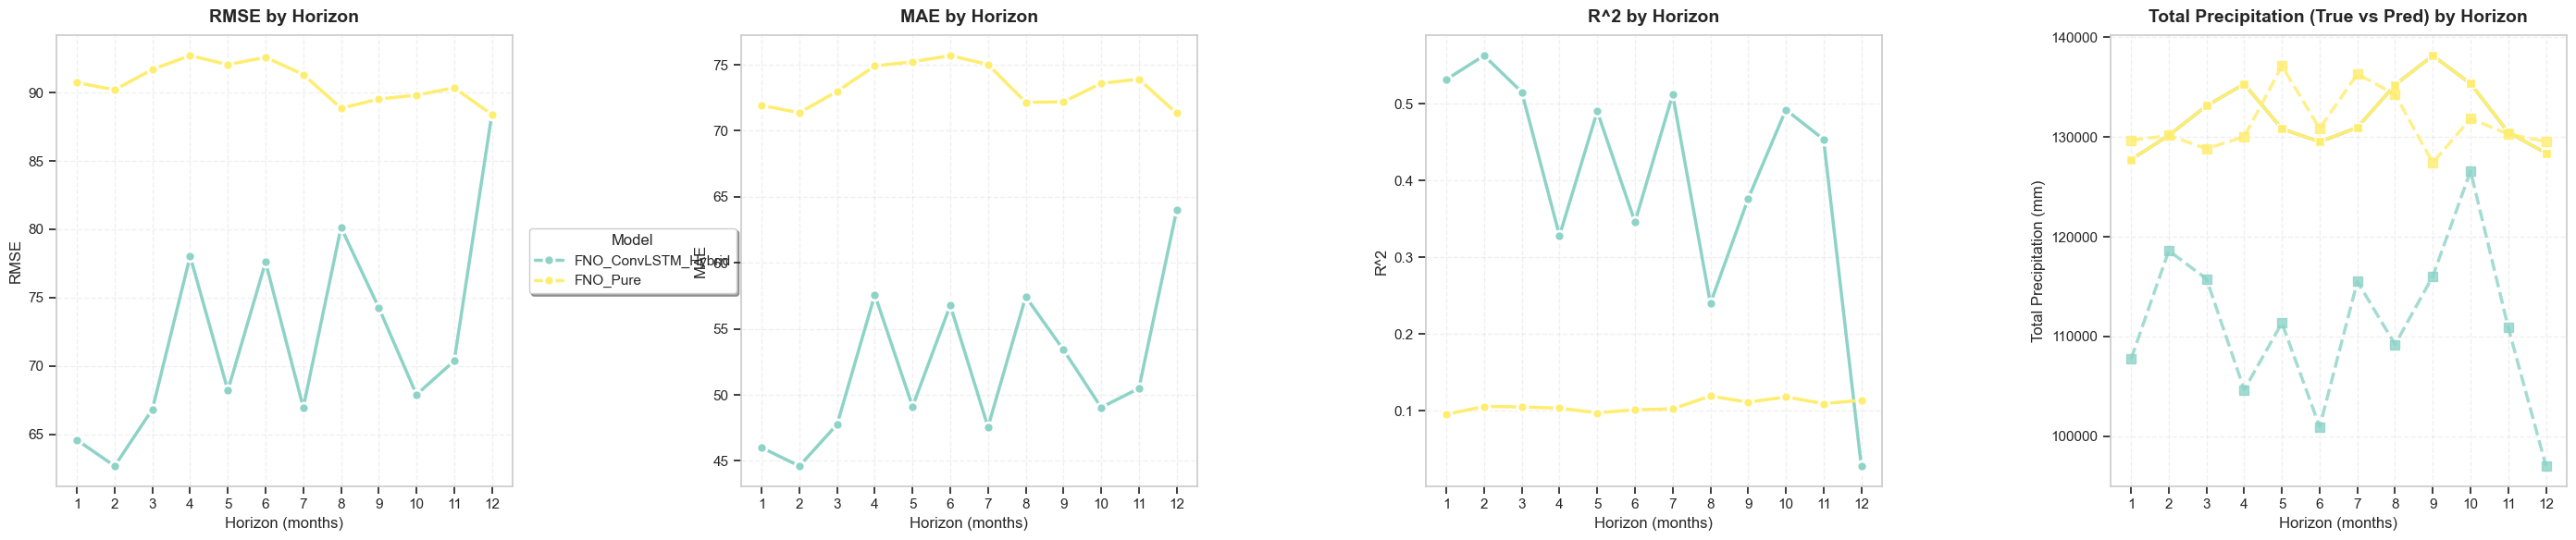

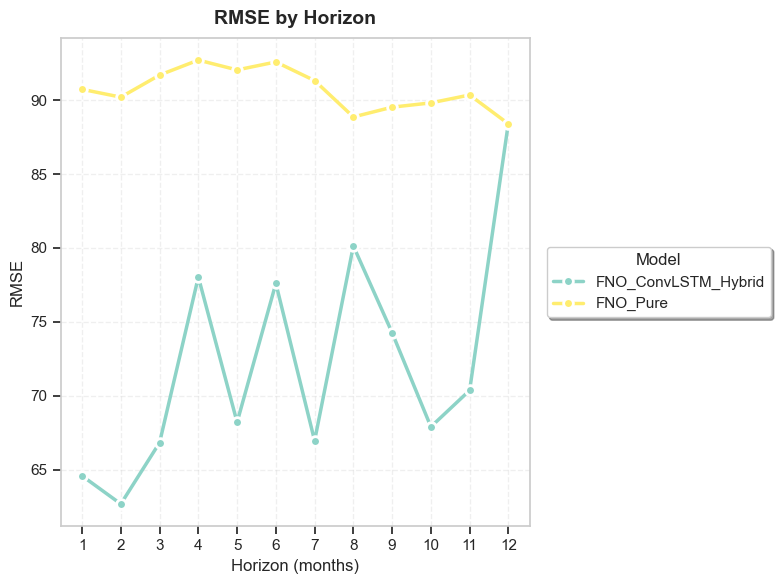

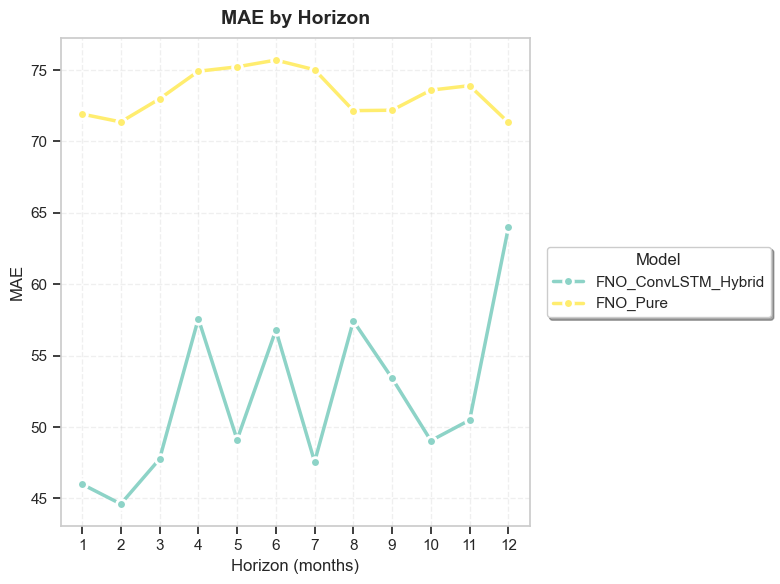

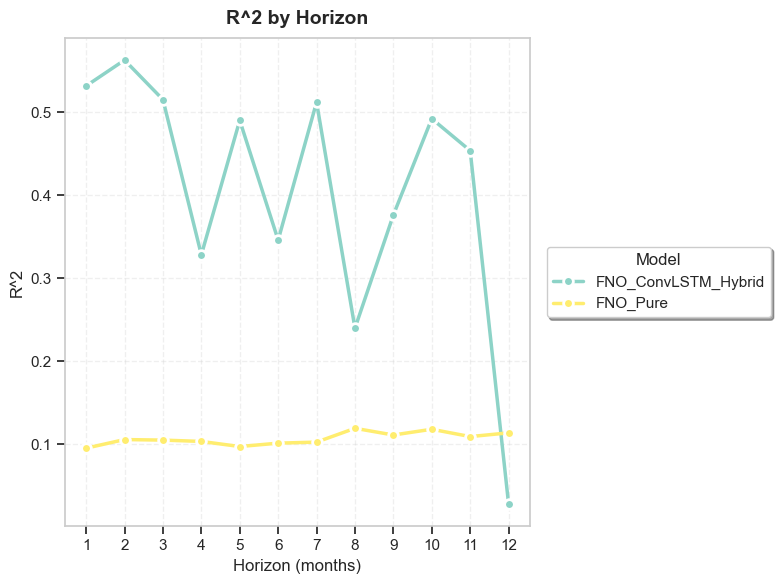

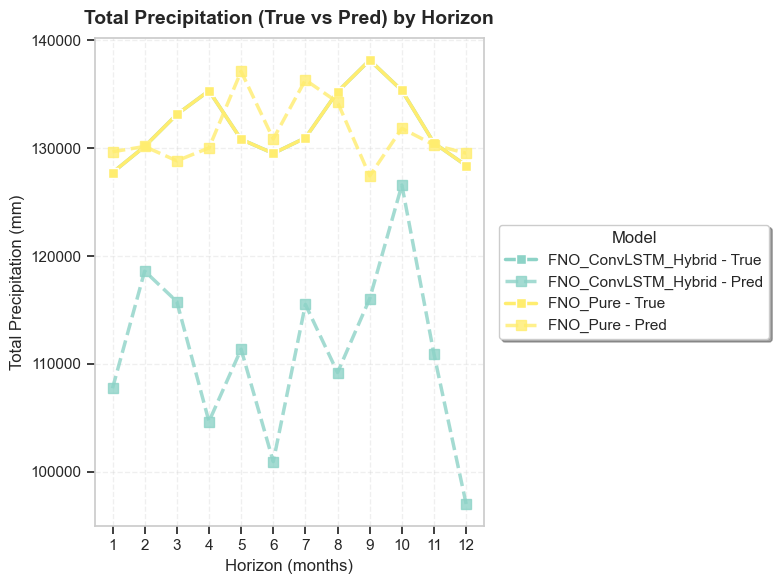

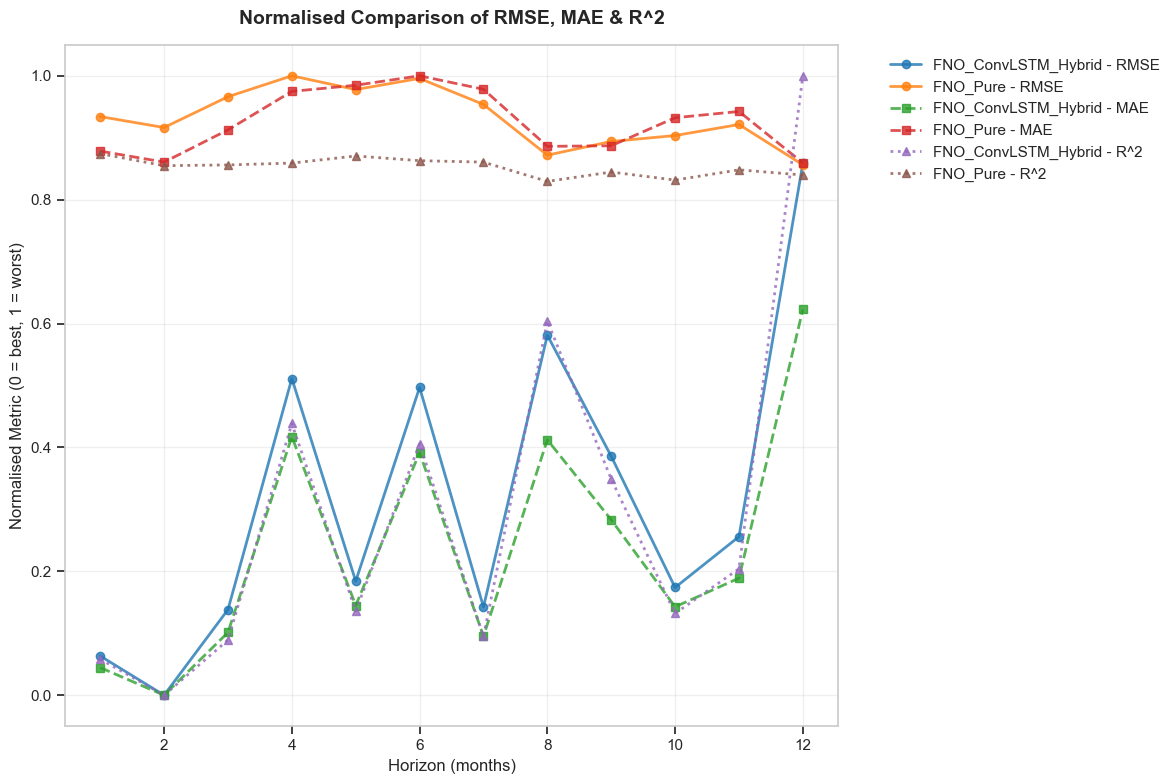

Enhanced plots saved to: d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V3_FNO_Models\comparisons


In [13]:

print("Generating enhanced evolution-by-horizon plots...")

# Helper: load res_df from saved CSV if not already in memory
def _maybe_load_res_df_from_disk():
    import pandas as pd
    from pathlib import Path
    candidates = []
    try:
        if 'CONFIG' in globals() and 'out_root' in CONFIG:
            candidates += sorted(Path(CONFIG['out_root']).glob('metrics_spatial_v2_refactored_*.csv'))
    except Exception:
        pass
    candidates += sorted(Path('.').glob('metrics_spatial_v2_refactored_*.csv'))
    for path in sorted(candidates, key=lambda p: p.stat().st_mtime, reverse=True):
        try:
            df = pd.read_csv(path)
            print(f"Loaded res_df from {path}")
            return df
        except Exception as e:
            print(f"Could not load {path}: {e}")
    return None

# Attempt lazy loading if res_df is missing or empty
if ('res_df' not in globals()) or (res_df.empty if 'res_df' in globals() else True):
    _tmp = _maybe_load_res_df_from_disk()
    if _tmp is not None:
        res_df = _tmp

if 'res_df' in globals() and not res_df.empty:
    # Iterate per TotalHorizon and produce plots for each
    for TH in sorted(res_df['TotalHorizon'].unique()):
        sub_df = res_df[res_df['TotalHorizon'] == TH].copy()
        if sub_df.empty:
            continue

        expected_models = set(MODELS.keys())
        present_models = set(sub_df['Model'].unique())
        missing_models = expected_models - present_models
        if missing_models:
            print(f"[WARN] Missing metrics for: {', '.join(sorted(missing_models))} (H={TH}). Re-run training if you expect them.")

        # Individual metrics per horizon (panel)
        fig, axes = plt.subplots(1, 4, figsize=(28, 6))
        metrics = ['RMSE', 'MAE', 'R^2', 'TotalPrecipitation']
        titles = ['RMSE by Horizon', 'MAE by Horizon', 'R^2 by Horizon', 'Total Precipitation (True vs Pred) by Horizon']
        metric_suffix = {'RMSE': 'rmse', 'MAE': 'mae', 'R^2': 'r2', 'TotalPrecipitation': 'totprecip'}
        model_list = list(sub_df['Model'].unique())
        colors = plt.cm.Set3(np.linspace(0, 1, max(1, len(model_list))))

        for idx, (metric, title) in enumerate(zip(metrics, titles)):
            ax = axes[idx]
            if metric != 'TotalPrecipitation':
                data = sub_df.groupby(['H', 'Model'])[metric].mean().unstack(fill_value=np.nan)
                for i, model in enumerate(data.columns):
                    ax.plot(data.index, data[model], marker='o', label=model, color=colors[i % len(colors)],
                            linewidth=2.5, markersize=8, markeredgewidth=2, markeredgecolor='white')
            else:
                data_true = sub_df.groupby(['H', 'Model'])['TotalPrecipitation'].mean().unstack(fill_value=np.nan)
                data_pred = sub_df.groupby(['H', 'Model'])['TotalPrecipitation_Pred'].mean().unstack(fill_value=np.nan)
                for i, model in enumerate(data_true.columns):
                    ax.plot(data_true.index, data_true[model], marker='s', label=f'{model} - True',
                            color=colors[i % len(colors)], linewidth=2.5, markersize=7, markeredgecolor='white')
                    ax.plot(data_pred.index, data_pred[model], marker='s', label=f'{model} - Pred',
                            color=colors[i % len(colors)], linewidth=2.5, linestyle='--', alpha=0.8, markersize=7)
            ylabel = metric if metric not in ('TotalPrecipitation', 'TotalPrecipitation_Pred') else 'Total Precipitation (mm)'
            ax.set_xlabel('Horizon (months)', fontsize=12)
            ax.set_ylabel(ylabel, fontsize=12)
            ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
            ax.grid(True, alpha=0.3, linestyle='--')
            ax.set_xticks(sorted(sub_df['H'].unique()))
            if idx == 0:
                # Legend outside the plotting area to the right
                ax.legend(title='Model', loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=True, fancybox=True, shadow=True, ncol=1)
            else:
                ax.legend().remove()

        plt.tight_layout()
        plt.subplots_adjust(hspace=0.4, wspace=0.5)
        panel_path = comp_dir / f'metrics_evolution_panel_h{TH}.png'
        plt.savefig(panel_path, dpi=300, bbox_inches='tight')
        plt.show()

        # Save split images (one per metric) with consistent naming
        for metric, title in zip(metrics, titles):
            fig, ax = plt.subplots(figsize=(8, 6))
            if metric != 'TotalPrecipitation':
                data = sub_df.groupby(['H', 'Model'])[metric].mean().unstack(fill_value=np.nan)
                for i, model in enumerate(data.columns):
                    ax.plot(data.index, data[model], marker='o', label=model, color=colors[i % len(colors)],
                            linewidth=2.5, markersize=7, markeredgewidth=2, markeredgecolor='white')
            else:
                data_true = sub_df.groupby(['H', 'Model'])['TotalPrecipitation'].mean().unstack(fill_value=np.nan)
                data_pred = sub_df.groupby(['H', 'Model'])['TotalPrecipitation_Pred'].mean().unstack(fill_value=np.nan)
                for i, model in enumerate(data_true.columns):
                    ax.plot(data_true.index, data_true[model], marker='s', label=f'{model} - True',
                            color=colors[i % len(colors)], linewidth=2.5, markersize=7, markeredgecolor='white')
                    ax.plot(data_pred.index, data_pred[model], marker='s', label=f'{model} - Pred',
                            color=colors[i % len(colors)], linewidth=2.5, linestyle='--', alpha=0.8, markersize=7)
            ylabel = metric if metric not in ('TotalPrecipitation', 'TotalPrecipitation_Pred') else 'Total Precipitation (mm)'
            ax.set_xlabel('Horizon (months)', fontsize=12)
            ax.set_ylabel(ylabel, fontsize=12)
            ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
            ax.grid(True, alpha=0.3, linestyle='--')
            ax.set_xticks(sorted(sub_df['H'].unique()))
            # Legend outside to the right for every split plot
            ax.legend(title='Model', loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=True, fancybox=True, shadow=True, ncol=1)
            plt.tight_layout()
            out_name = f'metrics_evolution_h{TH}_{metric_suffix[metric]}.png'
            plt.savefig(comp_dir / out_name, dpi=300, bbox_inches='tight')
            plt.show()

        # Normalized multi-metric comparison (kept as a single plot)
        fig, ax = plt.subplots(figsize=(12, 8))
        for metric in ['RMSE', 'MAE', 'R^2']:
            data = sub_df.groupby(['H', 'Model'])[metric].mean().unstack(fill_value=np.nan)
            # Normalize so that 0 = best, 1 = worst (R^2 inverted)
            global_min = data.min().min()
            global_max = data.max().max()
            if np.isfinite(global_min) and np.isfinite(global_max) and (global_max - global_min) > 0:
                if metric == 'R^2':
                    data_norm = 1 - (data - global_min) / (global_max - global_min + 1e-9)
                else:
                    data_norm = (data - global_min) / (global_max - global_min + 1e-9)
            else:
                data_norm = data * 0.0  # fallback if constant or NaN
            for i, model in enumerate(data_norm.columns):
                linestyle = '-' if metric == 'RMSE' else '--' if metric == 'MAE' else ':'
                marker = 'o' if metric == 'RMSE' else 's' if metric == 'MAE' else '^'
                ax.plot(data_norm.index, data_norm[model], marker=marker, linewidth=2, linestyle=linestyle,
                        label=f'{model} - {metric}', alpha=0.8)
        ax.set_xlabel('Horizon (months)', fontsize=12)
        ax.set_ylabel('Normalised Metric (0 = best, 1 = worst)', fontsize=12)
        ax.set_title('Normalised Comparison of RMSE, MAE & R^2', fontsize=14, fontweight='bold', pad=15)
        ax.grid(True, alpha=0.3)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.4, wspace=0.3)
        plt.savefig(comp_dir / f'normalized_metrics_comparison_h{TH}.png', dpi=300, bbox_inches='tight')
        plt.show()

    print("Enhanced plots saved to:", comp_dir)
else:
    print("No results available in res_df to plot (res_df is missing or empty).")


Generating visual metrics table...


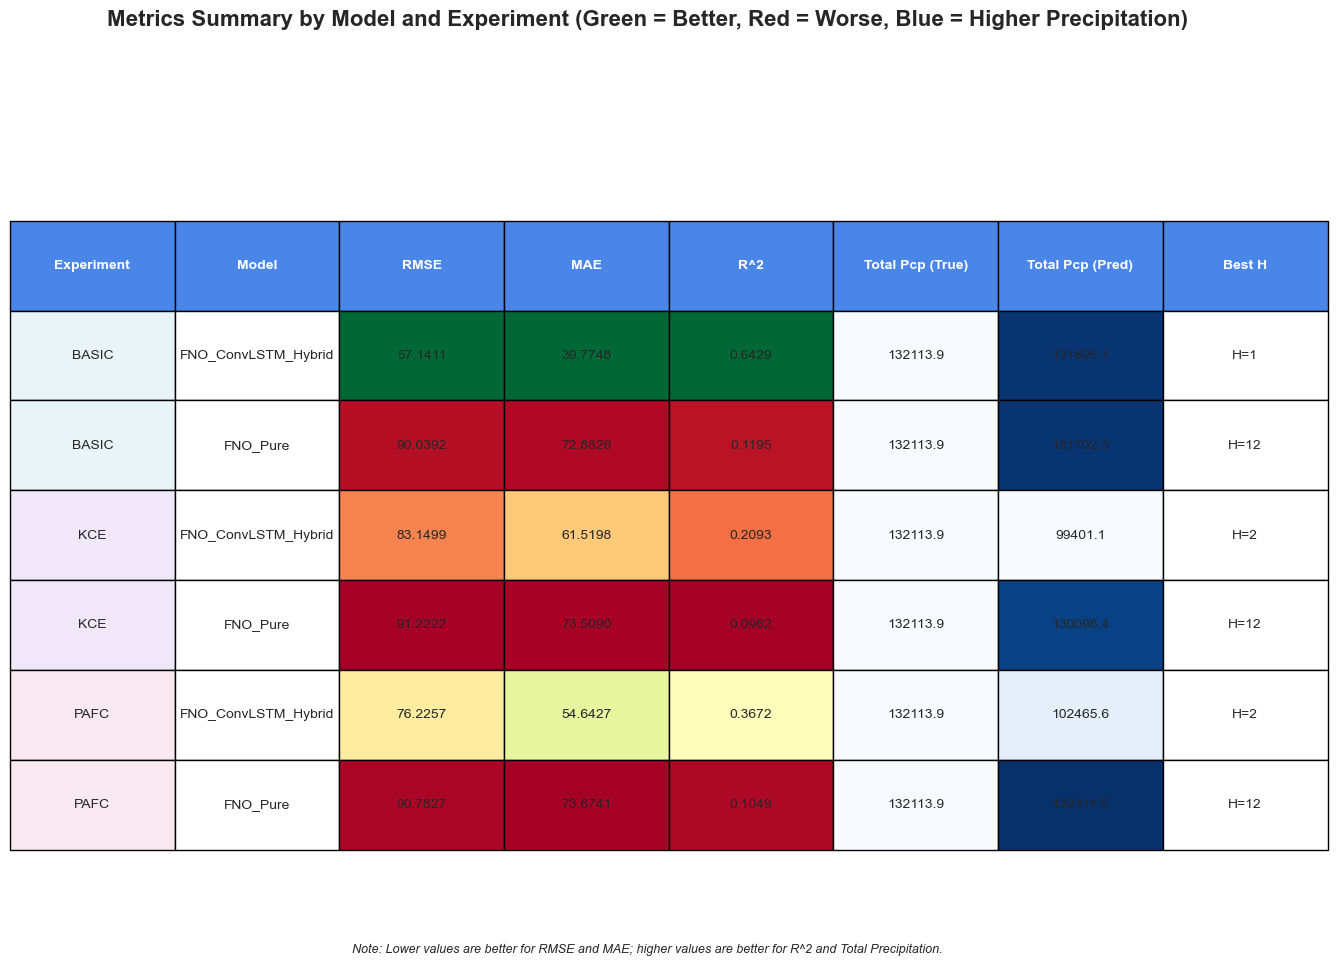

Model:                 FNO_ConvLSTM_Hybrid
Experiment:            BASIC
Horizon:               9
RMSE:                  59.5891
MAE:                   41.6662
R^2:                  0.6062
Total Precipitation:   138181.7
Composite score:       0.9352
All visualizations generated and saved!


In [14]:

print("Generating visual metrics table...")

import pandas as pd
from pathlib import Path

# Helper: load res_df from saved CSV if not already in memory
def _maybe_load_res_df_from_disk():
    candidates = []
    try:
        if 'CONFIG' in globals() and 'out_root' in CONFIG:
            candidates += sorted(Path(CONFIG['out_root']).glob('metrics_spatial_v2_refactored_*.csv'))
            candidates += sorted(Path(CONFIG['out_root']).glob('metrics_spatial_v2_enhanced*.csv'))
            candidates += sorted(Path(CONFIG['out_root']).glob('metrics_spatial_v3_*.csv'))
    except Exception:
        pass
    candidates += sorted(Path('.').glob('metrics_spatial_v2_refactored_*.csv'))
    for path in sorted(candidates, key=lambda p: p.stat().st_mtime, reverse=True):
        try:
            df = pd.read_csv(path)
            print(f"Loaded res_df from {path}")
            return df
        except Exception as e:
            print(f"Could not load {path}: {e}")
    return None

res_df = globals().get('res_df', None)
if res_df is None or getattr(res_df, 'empty', True):
    _tmp = _maybe_load_res_df_from_disk()
    if _tmp is not None:
        res_df = _tmp

if res_df is None or res_df.empty:
    print("No results available to build summary table; skipping.")
else:
    summary_data = []
    experiments = res_df['Experiment'].unique()
    models = res_df['Model'].unique()
    headers = ['Experiment', 'Model', 'RMSE', 'MAE', 'R^2', 'Total Pcp (True)', 'Total Pcp (Pred)', 'Best H']

    for exp in experiments:
        for model in models:
            sub = res_df[(res_df['Experiment'] == exp) & (res_df['Model'] == model)]
            if sub.empty:
                continue
            avg_rmse = sub['RMSE'].mean(); avg_mae = sub['MAE'].mean(); avg_r2 = sub['R^2'].mean()
            avg_tp_t = sub['TotalPrecipitation'].mean(); avg_tp_p = sub['TotalPrecipitation_Pred'].mean()
            best_h = sub.loc[sub['RMSE'].idxmin(), 'H']
            summary_data.append([
                exp, model,
                f'{avg_rmse:.4f}', f'{avg_mae:.4f}', f'{avg_r2:.4f}',
                f'{avg_tp_t:.1f}', f'{avg_tp_p:.1f}', f'H={best_h}'
            ])

    if not summary_data:
        print("No summary data to display.")
    else:
        fig, ax = plt.subplots(figsize=(17, 10))
        ax.axis('off')
        table = ax.table(cellText=summary_data, colLabels=headers, cellLoc='center', loc='center', bbox=[0, 0, 1, 0.85])
        table.auto_set_font_size(False); table.set_fontsize(10); table.scale(1.15, 1.8)

        all_rmse = [float(r[2]) for r in summary_data]; all_mae = [float(r[3]) for r in summary_data];
        all_r2 = [float(r[4]) for r in summary_data]; all_tp_t = [float(r[5]) for r in summary_data]; all_tp_p = [float(r[6]) for r in summary_data]

        for i, row in enumerate(summary_data):
            rmse = float(row[2]); mae = float(row[3]); r2 = float(row[4]); tp_t = float(row[5]); tp_p = float(row[6])
            rmse_norm = (rmse - min(all_rmse)) / (max(all_rmse) - min(all_rmse) + 1e-9)
            mae_norm = (mae - min(all_mae)) / (max(all_mae) - min(all_mae) + 1e-9)
            table[(i+1, 2)].set_facecolor(plt.cm.RdYlGn(1 - rmse_norm))
            table[(i+1, 3)].set_facecolor(plt.cm.RdYlGn(1 - mae_norm))
            r2_norm = (r2 - min(all_r2)) / (max(all_r2) - min(all_r2) + 1e-9)
            table[(i+1, 4)].set_facecolor(plt.cm.RdYlGn(r2_norm))
            tp_t_norm = (tp_t - min(all_tp_t)) / (max(all_tp_t) - min(all_tp_t) + 1e-9)
            tp_p_norm = (tp_p - min(all_tp_p)) / (max(all_tp_p) - min(all_tp_p) + 1e-9)
            table[(i+1, 5)].set_facecolor(plt.cm.Blues(tp_t_norm))
            table[(i+1, 6)].set_facecolor(plt.cm.Blues(tp_p_norm))
            pastel = {'BASIC': '#e8f4f8', 'KCE': '#f0e8f8', 'PAFC': '#f8e8f0'}
            table[(i+1, 0)].set_facecolor(pastel.get(row[0], '#ffffff'))

        for j in range(len(headers)):
            table[(0, j)].set_facecolor('#4a86e8')
            table[(0, j)].set_text_props(weight='bold', color='white')

        fig.suptitle('Metrics Summary by Model and Experiment (Green = Better, Red = Worse, Blue = Higher Precipitation)', fontsize=16, fontweight='bold', y=0.95)
        fig.text(0.5, 0.01, "Note: Lower values are better for RMSE and MAE; higher values are better for R^2 and Total Precipitation.", ha='center', va='center', fontsize=9, style='italic')
        plt.subplots_adjust(top=0.85)
        comp_dir = CONFIG.get('out_root', Path('.'))
        plt.savefig(comp_dir / 'metrics_summary_table.png', dpi=300, bbox_inches='tight', pad_inches=0.5)
        plt.show()

        res_df = res_df.copy()
        res_df['score'] = (
            (1 - (res_df['RMSE'] - res_df['RMSE'].min()) / (res_df['RMSE'].max() - res_df['RMSE'].min())) +
            (1 - (res_df['MAE'] - res_df['MAE'].min()) / (res_df['MAE'].max() - res_df['MAE'].min())) +
            ((res_df['R^2'] - res_df['R^2'].min()) / (res_df['R^2'].max() - res_df['R^2'].min())) +
            ((res_df['TotalPrecipitation'] - res_df['TotalPrecipitation'].min()) / (res_df['TotalPrecipitation'].max() - res_df['TotalPrecipitation'].min()))
        ) / 4
        best = res_df.loc[res_df['score'].idxmax()]
        print(f"Model:                 {best['Model']}")
        print(f"Experiment:            {best['Experiment']}")
        print(f"Horizon:               {best['H']}")
        print(f"RMSE:                  {best['RMSE']:.4f}")
        print(f"MAE:                   {best['MAE']:.4f}")
        print(f"R^2:                  {best['R^2']:.4f}")
        print(f"Total Precipitation:   {best['TotalPrecipitation']:.1f}")
        print(f"Composite score:       {best['score']:.4f}")

print("All visualizations generated and saved!")


In [15]:
# ==================================================
# MAP EXPORTS (Real vs Pred vs MAPE)
# ==================================================
import json
import pandas as pd
import imageio.v2 as imageio
import geopandas as gpd
import gc

SHAPE_DIR = CONFIG["base_path"] / "data" / "input" / "shapes"


def _load_boyaca_shape(shape_dir):
    """Load Boyaca geometry safely even if the shapefile lacks attributes."""
    if not shape_dir.exists():
        print(f"[WARN] Shape directory not found: {shape_dir}")
        return None, None

    shp_path = shape_dir / "MGN_Departamento.shp"
    try:
        dept_gdf = gpd.read_file(shp_path)
    except Exception as e:
        print(f"[WARN] Failed to read shapefile {shp_path}: {e}")
        return None, None

    if dept_gdf is None or dept_gdf.empty:
        print(f"[WARN] Shapefile is empty: {shp_path}")
        return dept_gdf, None

    # Try to locate a column with the department name; fall back to single-geometry files
    col_candidates = [c for c in dept_gdf.columns if c.lower() in {
        "nombre_dpt", "nombre_dept", "nombre", "departamen", "dpto"}]
    boyaca = None
    if col_candidates:
        name_col = col_candidates[0]
        boyaca = dept_gdf[dept_gdf[name_col].astype(str).str.upper().str.contains("BOYACA", na=False)].copy()
    elif len(dept_gdf) == 1:
        boyaca = dept_gdf.copy()
        print("[INFO] No name column found; assuming the single feature corresponds to Boyaca")
    else:
        print(f"[WARN] Could not identify Boyaca geometry; columns present: {list(dept_gdf.columns)}")

    if boyaca is not None and boyaca.empty:
        print("[WARN] Boyaca geometry not found in shapefile; overlay disabled")
        boyaca = None

    return dept_gdf, boyaca


DEPT_GDF, BOYACA = _load_boyaca_shape(SHAPE_DIR)

# Configuration for map generation
PLOT_HORIZONS = CONFIG.get('enabled_horizons', [CONFIG['horizon']])
PLOT_EXPERIMENTS = None  # e.g., ['KCE', 'PAFC']; None => all available
PLOT_MODELS = None       # e.g., ['ConvLSTM', 'ConvLSTM_Attention']; None => all in MODELS
MAP_SAMPLE_INDEX = -1    # which validation window to plot (-1 = most recent)
CYCLE_ALL_VAL_WINDOWS = True  # if True, export every validation window as a continuous month-by-month cycle
SAVE_EXPORTS = True      # persist predictions/targets/metadata for later reuse
AUTO_TRAIN_IF_MISSING = True  # auto-train and save weights if best checkpoint is missing
MAP_OUT_ROOT = CONFIG['out_root'] / 'map_exports'
EXPORT_DPI = 300        # lower DPI to reduce memory usage when saving PNGs
GIF_FRAME_DURATION = 1.5

lats = ds.latitude.values
lons = ds.longitude.values
EXTENT = [float(lons.min()), float(lons.max()), float(lats.min()), float(lats.max())]


def _ensure_weights(exp_name: str, model_name: str, horizon: int, data_splits: dict):
    """Ensure weights exist; auto-train if enabled and missing."""
    weights_path = CONFIG['out_root'] / f'h{horizon}' / exp_name / 'training_metrics' / f'{model_name}_best_h{horizon}.weights.h5'
    if weights_path.exists():
        return weights_path
    if not AUTO_TRAIN_IF_MISSING:
        raise FileNotFoundError(f'Weights not found: {weights_path}')

    if exp_name not in data_splits:
        raise FileNotFoundError(f'Data splits for {exp_name} not found; cannot auto-train {model_name}')
    print(f"[AUTO_TRAIN] {exp_name} - {model_name} - H{horizon}: training because weights are missing")
    try:
        X_tr, y_tr, X_va, y_va, _ = data_splits[exp_name]
        model = MODELS[model_name](len(CONFIG['feature_sets'][exp_name]), lat, lon, horizon)
        model, _ = train_model(model, X_tr, y_tr, X_va, y_va, CONFIG, model_name, exp_name, CONFIG['out_root'], horizon)
    except Exception as e:
        raise FileNotFoundError(f'Auto-train failed for {model_name} ({exp_name}, H{horizon}): {e}')

    if not weights_path.exists():
        try:
            model.save_weights(str(weights_path))
            print(f"[AUTO_TRAIN] Saved fallback weights to {weights_path}")
        except Exception:
            pass
    return weights_path


def _forecast_dates(val_indices: list[int], horizon: int) -> list[list[str]]:
    times = pd.to_datetime(ds.time.values)
    dates = []
    for start in val_indices:
        base = start + CONFIG['input_window']
        horizon_dates = []
        for h in range(horizon):
            idx = base + h
            if idx < len(times):
                horizon_dates.append(pd.Timestamp(times[idx]).strftime('%Y-%m'))
        dates.append(horizon_dates)
    return dates


def _load_or_generate(exp_name: str, model_name: str, horizon: int,
                      data_splits: dict, val_indices: list[int], forecast_dates: list[list[str]]):
    export_dir = MAP_OUT_ROOT / f'H{horizon}' / exp_name / model_name
    pred_f = export_dir / 'predictions.npy'
    targ_f = export_dir / 'targets.npy'
    meta_f = export_dir / 'metadata.json'

    if pred_f.exists() and targ_f.exists() and meta_f.exists():
        y_pred = np.load(pred_f)
        y_true = np.load(targ_f)
        meta = json.loads(meta_f.read_text())
        return y_pred, y_true, meta, export_dir

    X_tr, y_tr, X_va, y_va, y_scaler = data_splits[exp_name]
    weights_path = _ensure_weights(exp_name, model_name, horizon, data_splits)

    model = MODELS[model_name](len(CONFIG['feature_sets'][exp_name]), lat, lon, horizon)
    model.load_weights(str(weights_path))

    pred_batch = max(1, CONFIG.get('prediction_batch_size') or max(1, CONFIG['batch_size']))
    y_hat_sc = batch_predict(model, X_va, batch_size=pred_batch)
    if y_hat_sc.shape != y_va.shape:
        y_hat_sc = y_hat_sc.reshape(y_va.shape)
    y_pred = y_scaler.inverse_transform(y_hat_sc.reshape(-1, 1)).reshape(y_va.shape).astype(np.float32)
    y_true = y_scaler.inverse_transform(y_va.reshape(-1, 1)).reshape(y_va.shape).astype(np.float32)

    export_dir.mkdir(parents=True, exist_ok=True)
    meta = {
        'exp': exp_name,
        'model': model_name,
        'horizon': horizon,
        'input_window': CONFIG['input_window'],
        'train_val_split': CONFIG['train_val_split'],
        'val_indices': val_indices,
        'forecast_dates': forecast_dates,
        'sample_index': MAP_SAMPLE_INDEX,
        'features': CONFIG['feature_sets'][exp_name],
        'weights_path': str(weights_path),
    }
    if SAVE_EXPORTS:
        np.save(pred_f, y_pred.astype(np.float32))
        np.save(targ_f, y_true.astype(np.float32))
        meta_f.write_text(json.dumps(meta, indent=2))
    return y_pred, y_true, meta, export_dir


def _plot_triplet(ax, data, title, cmap, vmin=None, vmax=None):
    im = ax.imshow(data, origin='lower', extent=EXTENT, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=11)
    ax.set_xticks([])
    ax.set_yticks([])
    return im


def plot_maps():
    horizons = PLOT_HORIZONS
    experiments = PLOT_EXPERIMENTS or list(CONFIG['feature_sets'].keys())
    models_to_plot = PLOT_MODELS or list(MODELS.keys())

    for horizon in horizons:
        data_splits_h = preprocess_data(ds, CONFIG, lat, lon, horizon)
        _, val_idx = compute_split_indices(len(ds.time), CONFIG['input_window'], horizon, CONFIG['train_val_split'])
        forecast_dates = _forecast_dates(val_idx, horizon)

        for exp_name in experiments:
            if exp_name not in data_splits_h:
                print(f'[SKIP] {exp_name} not available for H={horizon}')
                continue
            for model_name in models_to_plot:
                if model_name not in MODELS:
                    continue
                try:
                    y_pred, y_true, meta, export_dir = _load_or_generate(exp_name, model_name, horizon, data_splits_h, val_idx, forecast_dates)
                except FileNotFoundError as e:
                    print(f'[SKIP] {exp_name} - {model_name} - H{horizon}: {e}')
                    continue
                if y_pred.size == 0 or y_true.size == 0:
                    print(f'[SKIP] {exp_name} - {model_name} - H{horizon}: empty arrays')
                    continue
                if CYCLE_ALL_VAL_WINDOWS:
                    indices_to_plot = range(len(y_true))
                else:
                    idx = MAP_SAMPLE_INDEX if MAP_SAMPLE_INDEX >= 0 else (len(y_true) - 1)
                    idx = max(min(idx, len(y_true) - 1), 0)
                    indices_to_plot = [idx]

                frame_count = 0
                gif_path = export_dir / f'{model_name}_H{horizon}.gif'
                writer = None
                for idx in indices_to_plot:
                    sample_dates = meta.get('forecast_dates', forecast_dates)[idx]
                    for h in range(min(horizon, len(sample_dates))):
                        real = y_true[idx, h, ..., 0]
                        pred = y_pred[idx, h, ..., 0]
                        err = np.abs(pred - real) / (np.abs(real) + 1e-6) * 100.0
                        fig, axes = plt.subplots(1, 3, figsize=(14, 4.5), constrained_layout=True)
                        im0 = _plot_triplet(axes[0], real, f'Real {sample_dates[h]}', 'Blues')
                        im1 = _plot_triplet(axes[1], pred, f'{model_name} H{h+1} {sample_dates[h]}', 'Blues')
                        im2 = _plot_triplet(axes[2], np.clip(err, 0, 100), f'MAPE% {model_name} H{h+1} {sample_dates[h]}', 'Reds', vmin=0, vmax=100)
                        if BOYACA is not None:
                            try:
                                BOYACA.boundary.plot(ax=axes[0], color='k', linewidth=0.8)
                                BOYACA.boundary.plot(ax=axes[1], color='k', linewidth=0.8)
                                BOYACA.boundary.plot(ax=axes[2], color='k', linewidth=0.8)
                            except Exception as e:
                                print(f"[WARN] shapefile overlay failed: {e}")
                        cbar0 = fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
                        cbar0.set_label('Precipitation (mm)', rotation=270, labelpad=12)
                        cbar1 = fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
                        cbar1.set_label('Precipitation (mm)', rotation=270, labelpad=12)
                        cbar2 = fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
                        cbar2.set_label('MAPE (%)', rotation=270, labelpad=12)
                        title = f'{exp_name} | {model_name} | H{horizon} | {sample_dates[h]}'
                        fig.suptitle(title, fontsize=12)
                        export_dir.mkdir(parents=True, exist_ok=True)
                        png_path = export_dir / f'{model_name}_H{horizon}_{sample_dates[h]}.png'
                        fig.savefig(png_path, dpi=EXPORT_DPI) # Removed bbox_inches='tight'
                        plt.close(fig)
                        frame = imageio.imread(png_path)
                        if writer is None:
                            writer = imageio.get_writer(gif_path, mode='I', duration=GIF_FRAME_DURATION, loop=0)
                        writer.append_data(frame)
                        frame_count += 1
                        del frame, real, pred, err
                        gc.collect()
                if writer is not None:
                    writer.close()
                print(f'[OK] {exp_name} - {model_name} - H{horizon}: saved {frame_count} frames to {export_dir}')
                del y_pred, y_true
                gc.collect()

plot_maps()

[INFO] No name column found; assuming the single feature corresponds to Boyaca
Preprocessing BASIC...
BASIC processed: 343 train windows, 33 validation windows
Preprocessing KCE...
KCE processed: 343 train windows, 33 validation windows
Preprocessing PAFC...
PAFC processed: 343 train windows, 33 validation windows
[OK] BASIC - FNO_ConvLSTM_Hybrid - H12: saved 396 frames to d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V3_FNO_Models\map_exports\H12\BASIC\FNO_ConvLSTM_Hybrid
[OK] BASIC - FNO_Pure - H12: saved 396 frames to d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V3_FNO_Models\map_exports\H12\BASIC\FNO_Pure
[OK] KCE - FNO_ConvLSTM_Hybrid - H12: saved 396 frames to d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V3_FNO_Models\map_exports\H12\KCE\FNO_ConvLSTM_Hybrid
[OK] KCE - FNO_Pure - H12: saved 396 frames to d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V3_FNO_Models\map_exports\H12\KCE\FNO_P

In [16]:
# ==================================================
# CLEANUP AND TERMINATION
# ==================================================

print("TRAINING AND ANALYSIS COMPLETED!")
print(f"Models trained: {len(MODELS)} architectures")
print(f"Experiments completed: {len(CONFIG['feature_sets'])}")
print(f"Results saved to: {CONFIG['out_root']}")

# Cleanup
tf.keras.backend.clear_session()
gc.collect()
print("Memory cleared")

if IN_COLAB:
    print("\nTerminating Colab session to save resources...")
    from google.colab import runtime
    runtime.unassign()
else:
    print("\nLocal environment detected. Session remains active.")


TRAINING AND ANALYSIS COMPLETED!
Models trained: 2 architectures
Experiments completed: 3
Results saved to: d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V3_FNO_Models
Memory cleared

Local environment detected. Session remains active.
